In [279]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd



In [2]:
df_censo = pd.read_csv('../database/Cantidad-de-Personas-por-Sexo-y-Edad.csv', sep=";")
df_farmacias = pd.read_csv("../database/2.-Farmacias-Chile-07.2023.csv", sep=";", encoding="utf-8")
df_hospitales = pd.read_excel("../database/Establecimientos_ChileDEIS_MINSAL 03-11-2023.xlsx", sheet_name="Establecimientos Vigentes")

def modificar_nombre_columna(nombre: str):
    nombre = nombre.strip()  
    nombre = nombre.lower() 
    nombre = nombre.replace(" ", "_")
    nombre = nombre.replace("\xa0", "_")
    return nombre

nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_censo.columns}
df_censo.rename(columns=nuevos_nombres, inplace=True)
df_censo.columns

df_censo["código_región"] = pd.to_numeric(df_censo["código_región"], errors="coerce")
df_censo["código_provincia"] = pd.to_numeric(df_censo["código_provincia"], errors="coerce")
df_censo["código_comuna"] = pd.to_numeric(df_censo["código_comuna"], errors="coerce")
df_censo["edad"] = df_censo["edad"].astype("category")
df_censo["hombres"] = df_censo["hombres"].str.replace(".", "").astype("int")
df_censo["mujeres"] = df_censo["mujeres"].str.replace(".", "").astype("int")
df_censo["total"] = df_censo["total"].str.replace(".", "").astype("int")

In [3]:
df_hospitales.columns = df_hospitales.loc[0,:]
df_hospitales.drop(0, inplace=True)
df_hospitales.drop(columns=["Código Antiguo ", "Código  Madre Antiguo", "Código Madre Nuevo", "Código  Madre Antiguo", "Fecha de Incorporación a la base o cambios", "Teléfono", "Fecha Inicio Funcionamiento", "Vía", "Certificación ", "Número", "Dirección", "Clasificcion Tipo de SAPU", "Dependencia Administrativa"], inplace=True)

In [4]:
df_hospitales.replace(["No Aplica", "Pendiente", "Completar", "No Aplica", "Por confirmar", "no Aplica", "Pendiente", "no aplica", "No Aplica"], np.NaN, inplace=True)

df_hospitales["Código Vigente"] = df_hospitales["Código Vigente"].astype("int")

df_hospitales["Código Región"] = df_hospitales["Código Región"].astype("int")

df_hospitales["Código Dependencia Jerárquica (SEREMI / Servicio de Salud)"] = df_hospitales["Código Dependencia Jerárquica (SEREMI / Servicio de Salud)"].astype("float")

df_hospitales["Pertenencia al SNSS"] = df_hospitales["Pertenencia al SNSS"].map(lambda x: x == 'Perteneciente' or x == True)
df_hospitales["Pertenencia al SNSS"] = df_hospitales["Pertenencia al SNSS"].astype("bool")

df_hospitales["Nivel de Atención"] = df_hospitales["Nivel de Atención"].astype("category")

df_hospitales["Tiene Servicio de Urgencia"] = df_hospitales["Tiene Servicio de Urgencia"].map(lambda x: x == 'SI' or x == True)
df_hospitales["Tiene Servicio de Urgencia"] = df_hospitales["Tiene Servicio de Urgencia"].astype("bool")
df_hospitales["Tipo de Urgencia "] = df_hospitales["Tipo de Urgencia "].astype("category")
df_hospitales["Tipo de Prestador Sistema de Salud"] = df_hospitales["Tipo de Prestador Sistema de Salud"].astype("category")

df_hospitales["Nivel de Complejidad"] = df_hospitales["Nivel de Complejidad"].astype("category")
df_hospitales["Tipo de Atención "] = df_hospitales["Tipo de Atención "].astype("category")



In [5]:
df_hospitales = df_hospitales[df_hospitales['Estado de Funcionamiento'].str.contains("Vigente", case=False, na=False)]
df_hospitales.drop(columns="Estado de Funcionamiento", inplace=True)

In [6]:

nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_hospitales.columns}
df_hospitales.rename(columns=nuevos_nombres, inplace=True)
df_hospitales.rename(columns={"latitud______[grados_decimales]": "latitud", "longitud_[grados_decimales]":"longitud"}, inplace=True)
df_hospitales["código_región"] = df_hospitales["código_región"].astype("int")
df_hospitales["código_comuna"] = df_hospitales["código_comuna"].astype("int")
df_hospitales["tipo_establecimiento_(unidad)"] = df_hospitales["tipo_establecimiento_(unidad)"].str.strip()
df_hospitales["nombre_comuna"] = df_hospitales["nombre_comuna"].str.upper()
df_hospitales.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4525 entries, 1 to 4526
Data columns (total 19 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   código_vigente                                              4525 non-null   int64   
 1   código_región                                               4525 non-null   int64   
 2   nombre_región                                               4525 non-null   object  
 3   código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  4482 non-null   float64 
 4   nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  4483 non-null   object  
 5   pertenencia_al_snss                                         4525 non-null   bool    
 6   tipo_establecimiento_(unidad)                               4523 non-null   object  
 7   ámbito_de_funcionamiento                                    4525 non-null   object 

In [7]:
df_hospitales.loc[df_hospitales["nombre_región"] == "Región De los Ríos", "nombre_región"] = "Región De Los Ríos"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "CHILLÁN ", "nombre_comuna"] = "CHILLÁN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LICANTEN", "nombre_comuna"] = "LICANTÉN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "VICHUQUEN", "nombre_comuna"] = "VICHUQUÉN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "CALERA","nombre_comuna"] = "LA CALERA"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LAS CONDES", "código_comuna"] = 13114
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LA FLORIDA", "código_comuna"] = 13110


In [8]:
comunas_ñuble = {16109: 'YUNGAY',
 16105: 'PEMUCO',
 16104: 'EL CARMEN',
 16107: 'QUILLÓN',
 16108: 'SAN IGNACIO',
 16106: 'PINTO',
 16102: 'BULNES',
 16302: 'COIHUECO',
 16103: 'CHILLÁN VIEJO',
 16206: 'RÁNQUIL',
 16304: 'SAN FABIÁN',
 16101: 'CHILLÁN',
 16205: 'PORTEZUELO',
 16203: 'COELEMU',
 16305: 'SAN NICOLÁS',
 16301: 'SAN CARLOS',
 16207: 'TREGUACO',
 16204: 'NINHUE',
 16303: 'ÑIQUÉN',
 16201: 'QUIRIHUE',
 16202: 'COBQUECURA'}
comunas_ñuble = {v: k for k, v in comunas_ñuble.items()}


provincias_ñuble = {
    161: "DIGUILLÍN",
    162: "ITATA",
    163: "PUNILLA"
}


In [9]:
d = df_censo[df_censo["nombre_provincia"].str.contains("ÑUBLE")]
d["nombre_comuna"] = d["nombre_comuna"].str.replace(" *", "")
d
d["código_comuna"] = d["nombre_comuna"].map(comunas_ñuble).astype("string")
d["nombre_región"] = "ÑUBLE"
d["código_región"] = 16
d["código_provincia"] = d["código_comuna"].str.slice(0,3)
d["código_provincia"] = d["código_provincia"].astype("int")
d["nombre_provincia"] = d["código_provincia"].map(provincias_ñuble)





/tmp/ipykernel_896/4203659101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["nombre_comuna"] = d["nombre_comuna"].str.replace(" *", "")
/tmp/ipykernel_896/4203659101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["código_comuna"] = d["nombre_comuna"].map(comunas_ñuble).astype("string")
/tmp/ipykernel_896/4203659101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [10]:
df_censo.drop(df_censo[df_censo["nombre_provincia"].str.contains("ÑUBLE")].index, inplace=True)
df_censo = pd.concat([df_censo, d], ignore_index=True)
df_censo.sort_values(by="orden", inplace=True)
df_censo["código_comuna"] = df_censo["código_comuna"].astype("float")



In [11]:
codigo_comuna_a_provincia = dict(zip(df_censo['código_comuna'], df_censo['código_provincia']))
codigo_comuna_a_provincia = {int(comuna): int(provincia) for comuna, provincia in codigo_comuna_a_provincia.items() if not pd.isna(comuna)}
df_hospitales.loc[:, "código_provincia"] = df_hospitales["código_comuna"].map(codigo_comuna_a_provincia)
df_hospitales["código_provincia"] = df_hospitales["código_provincia"].astype("int")

In [12]:
codigo_comuna_a_provincia = dict(zip(df_censo['código_comuna'], df_censo['nombre_provincia']))
codigo_comuna_a_provincia = {int(comuna): str(provincia) for comuna, provincia in codigo_comuna_a_provincia.items() if not pd.isna(comuna)}
df_hospitales.loc[:, "nombre_provincia"] = df_hospitales["código_comuna"].map(codigo_comuna_a_provincia)
df_hospitales["código_provincia"] = df_hospitales["código_provincia"].astype("int")

### Comunas sin servicios de salud
La unica comuna en chile sin servicios de salud es la antártica

## Servicios de salud por region

In [13]:
df_hospitales_1 = df_hospitales[(~df_hospitales["tipo_de_prestador_sistema_de_salud"].isin(['Fuerzas Armadas y de Orden', 'Institución Medicina Legal']))]
df_hospitales_1 = df_hospitales_1[(~df_hospitales_1["ámbito_de_funcionamiento"].isin(['Hospital',
 'Posta de Salud Rural (PSR)',
 'Centro Comunitario de Salud Familiar (CECOSF)',
 'Servicio de Atención Primaria de Urgencia de Alta Resolutividad (SAR)',
 'Centro de Salud Familiar (CESFAM)',
 'Centro de Salud Privado',
 'Unidad de Salud Funcionarios',
 'Dirección Servicio de Salud',
 'Servicio de Atención Primaria de Urgencia (SAPU)',
 'Clínica',
 'Consultorio General Urbano  (CGU)',
 'Unidad de Procedimientos Móvil',
 'Servicio de Urgencia Rural (SUR)',
 'Centro de Diagnóstico y Terapeútico (CDT)',
 'Hospital de Día Infanto Adolescente',
 'Consultorio General Rural (CGR)',
 'Centro de Referencia de Salud (CRS)',
 'Centro Corporación para la Nutrición Infantil (CONIN)',
 'Hospital de Dia Adulto',
 'Puesto de Atención Médica Especializado (PAME) Incorporado por Crisis Sanitaria',
 'Centro de Especialidad',
 'Centros Exclusivos de Atención Respiratoria (CEAR)',
 'Especialidades  Primarias',
 'Centro de Regulación Médica de las Urgencias (SAMU)',
 'Centros de Diagnóstico y Tratamiento Privados',
 'Policlínico Funcionarios (Minería)',
 'Centro de Especialidades Primarias',
 'Centro Radiológico',
 'Centro de Salud']))]


In [81]:
df_poblacion = df_censo[df_censo["nombre_comuna"] != "PAÍS"]
df_poblacion_por_comuna = df_poblacion[df_poblacion["edad"] == "Total Comunal"]
df_poblacion_por_provincia = pd.pivot_table(df_poblacion_por_comuna, index="código_provincia", values=["hombres", "mujeres", "total"], aggfunc=np.sum)
df_poblacion_por_region = pd.pivot_table(df_poblacion_por_comuna, index="código_región", values=["hombres", "mujeres", "total"], aggfunc=np.sum)
df_poblacion_por_comuna = df_poblacion_por_comuna[["hombres", "mujeres", "total", "código_comuna"]]

df_poblacion_por_comuna_edad = df_poblacion[df_poblacion["edad"] != "Total Comunal"]
df_poblacion_por_comuna_edad = pd.pivot_table(data=df_poblacion_por_comuna_edad, index=["código_comuna","edad"], values=["hombres", "mujeres", "total"]).reset_index()

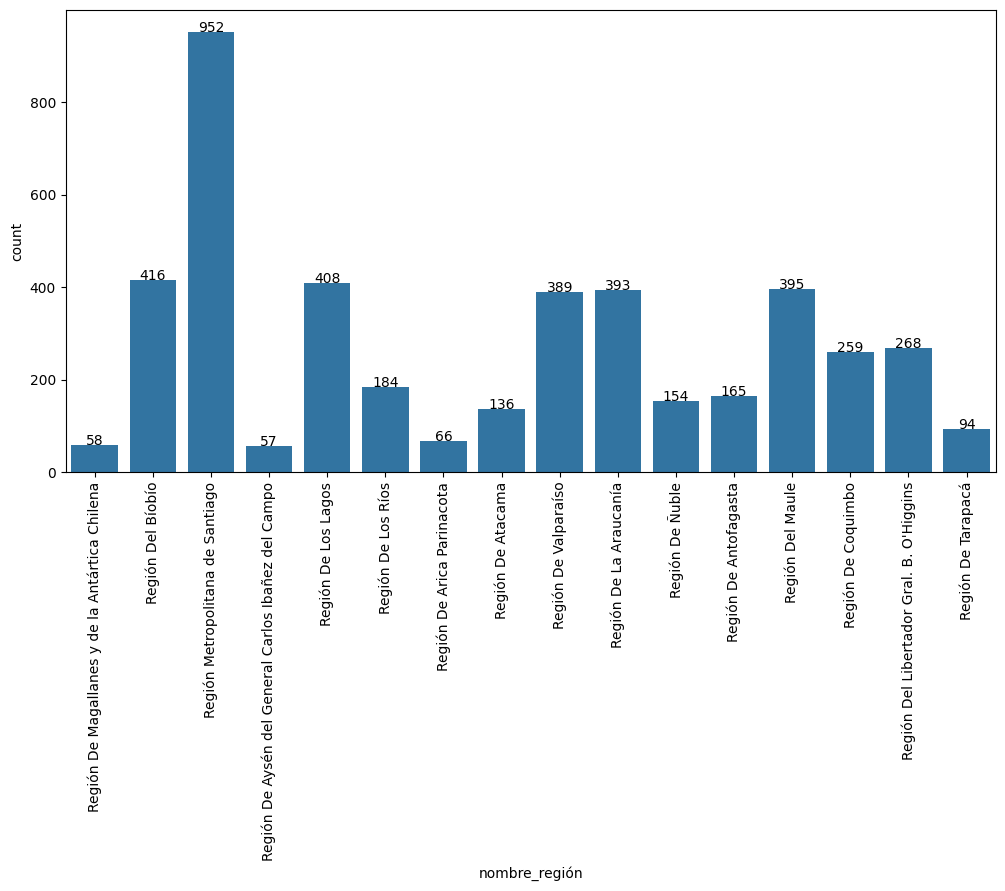

In [16]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="nombre_región", data=df_hospitales_1)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=90)
plt.show()

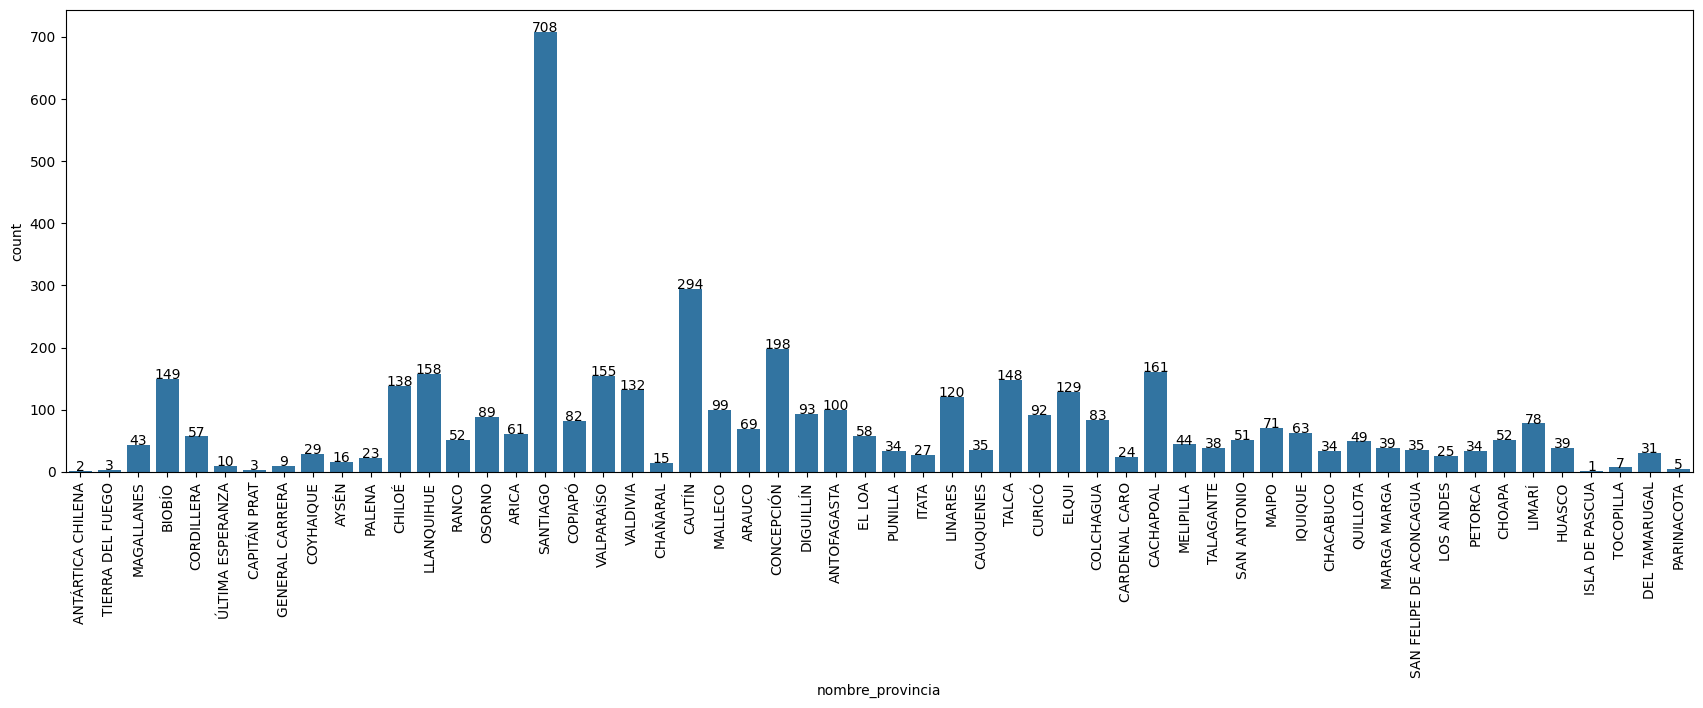

In [17]:
plt.figure(figsize=(21, 6))
ax = sns.countplot(x="nombre_provincia", data=df_hospitales_1)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=90)
plt.show()

<Figure size 2100x600 with 0 Axes>

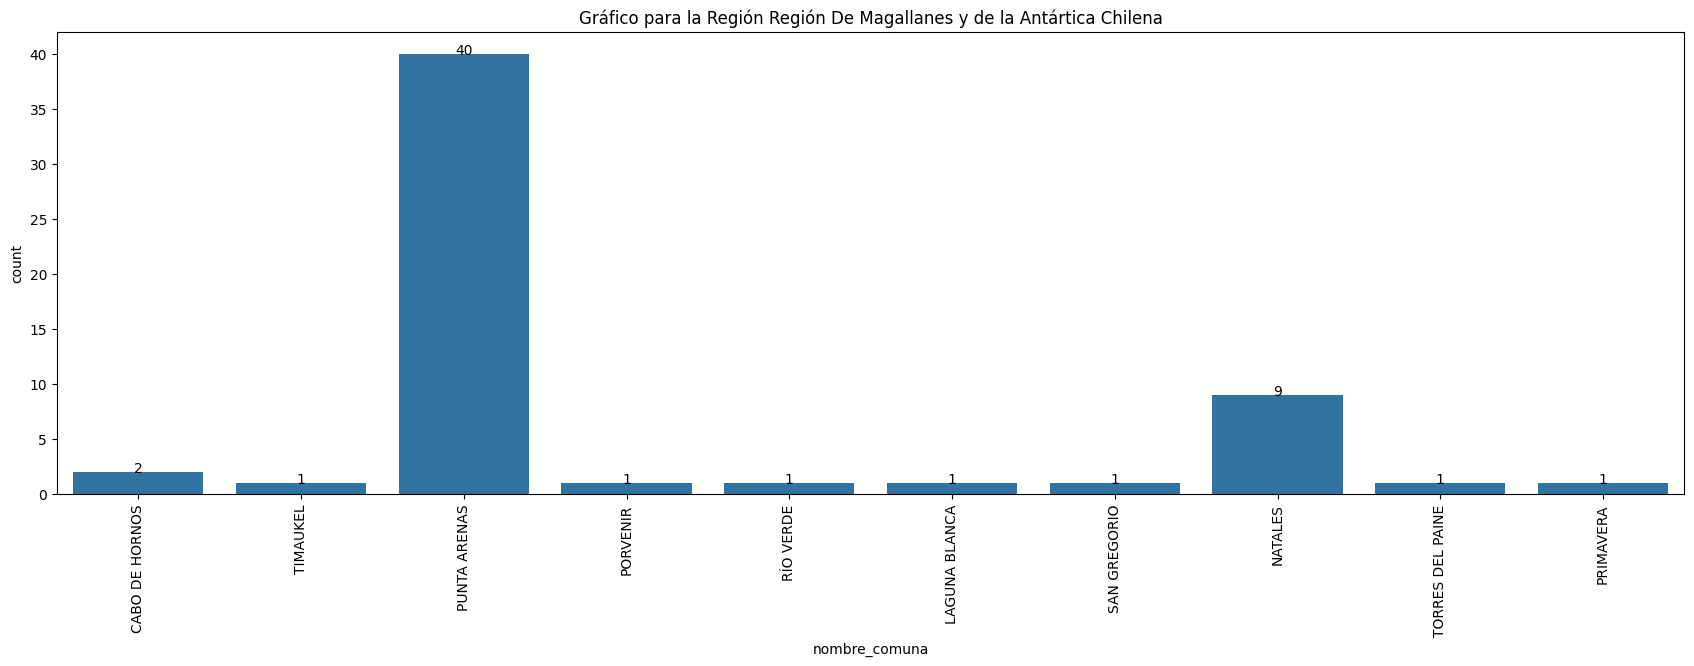

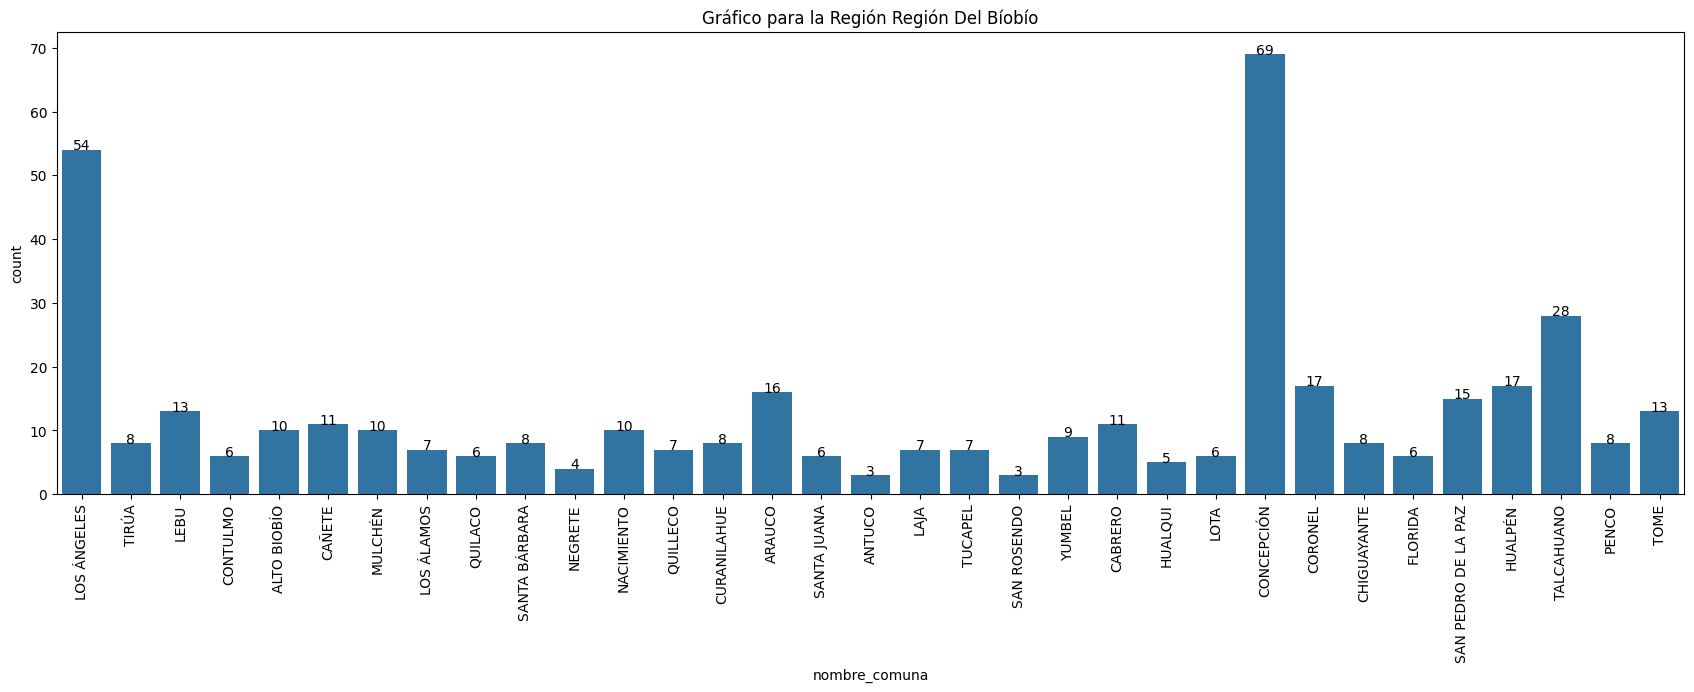

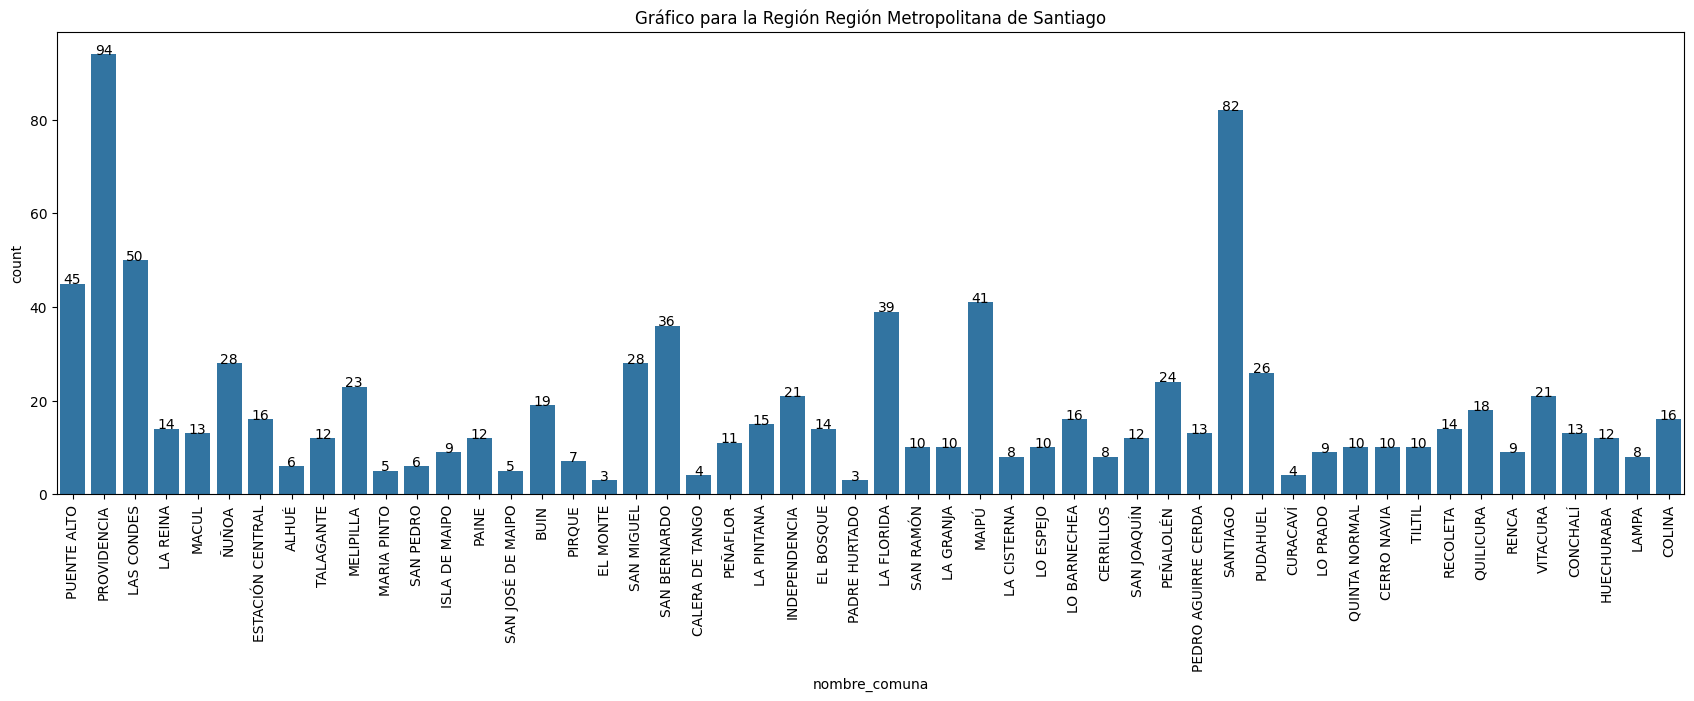

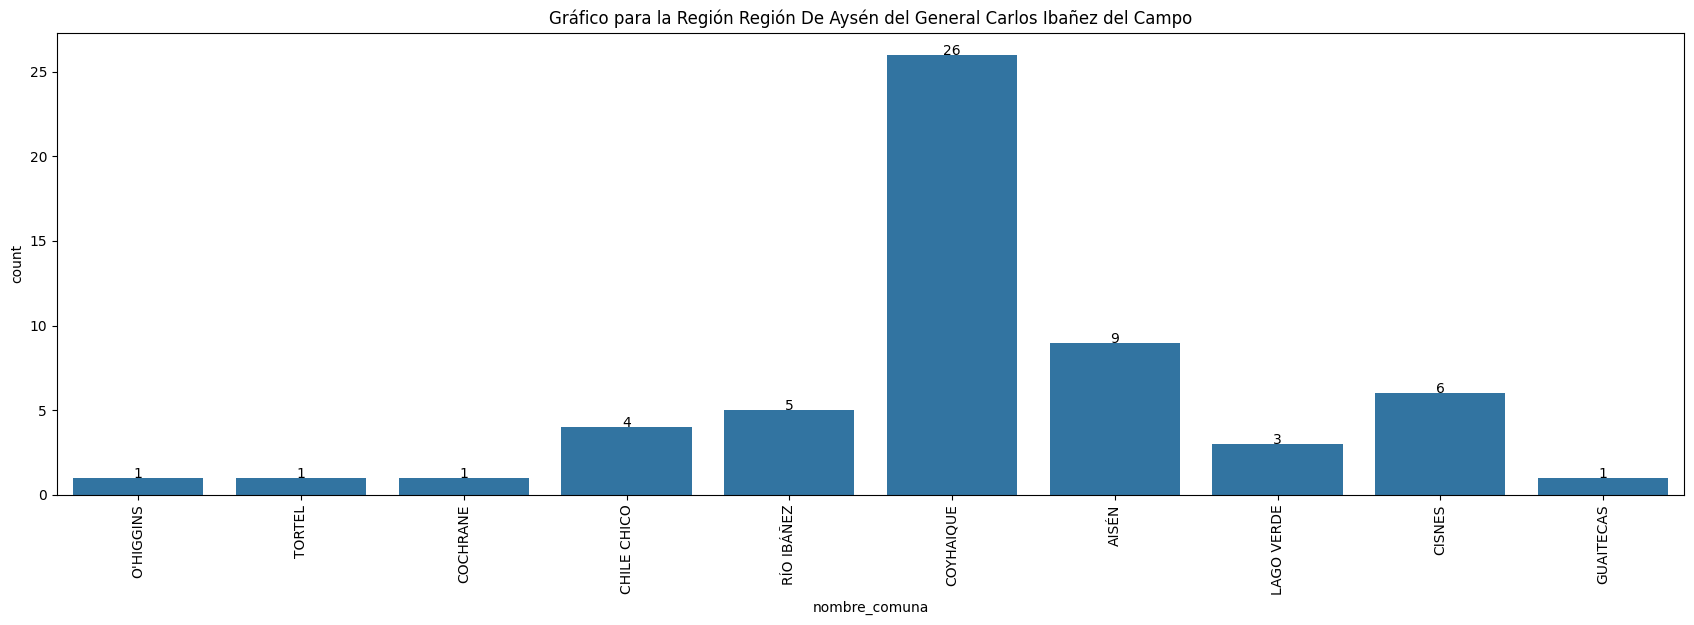

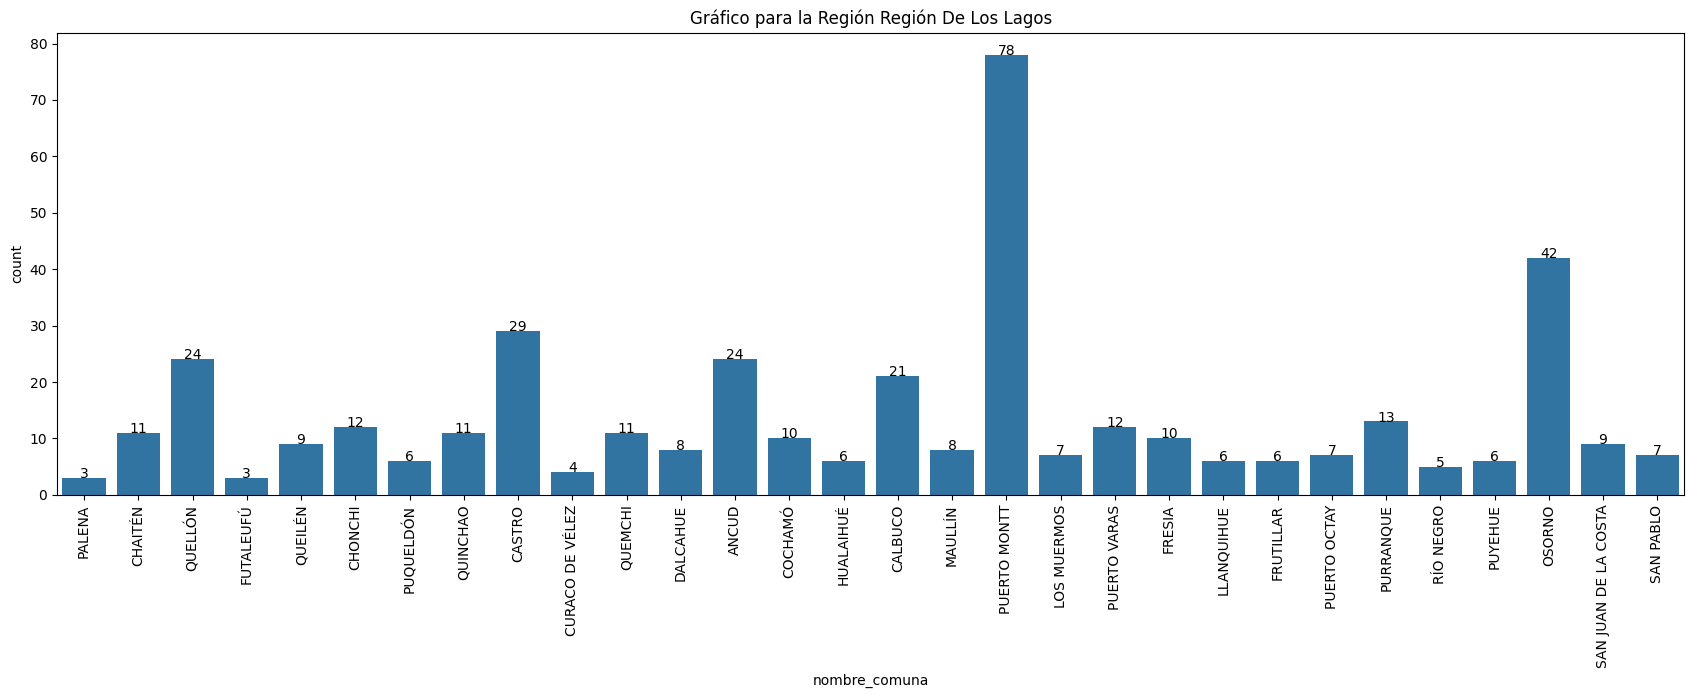

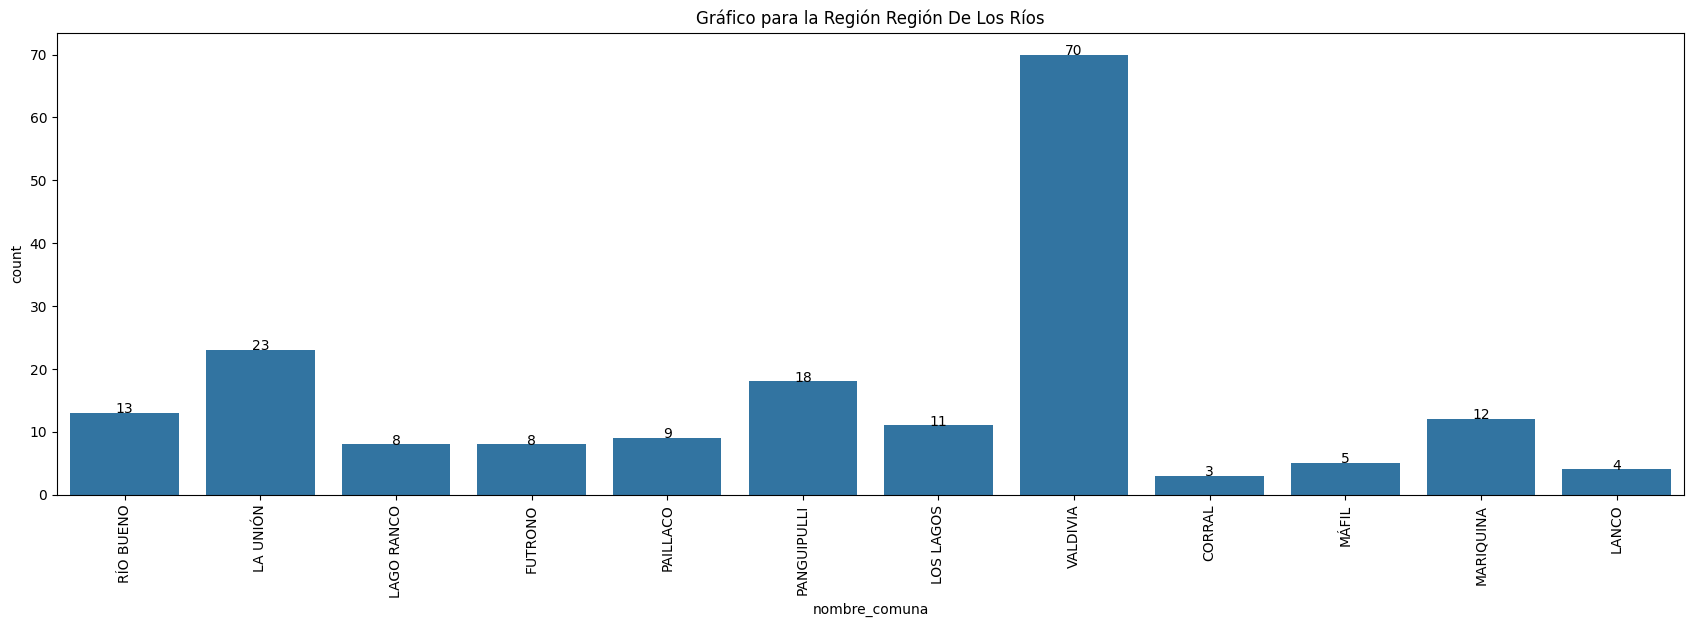

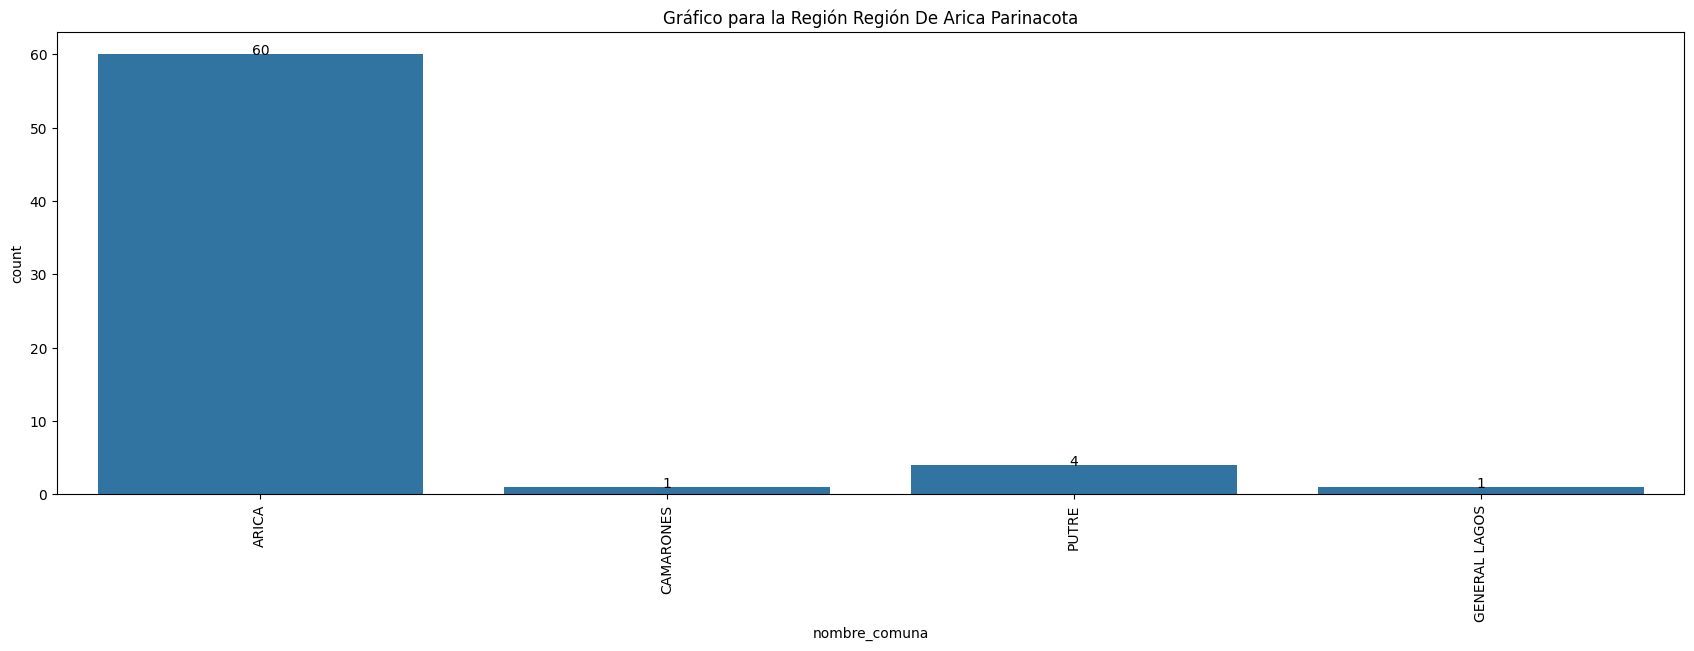

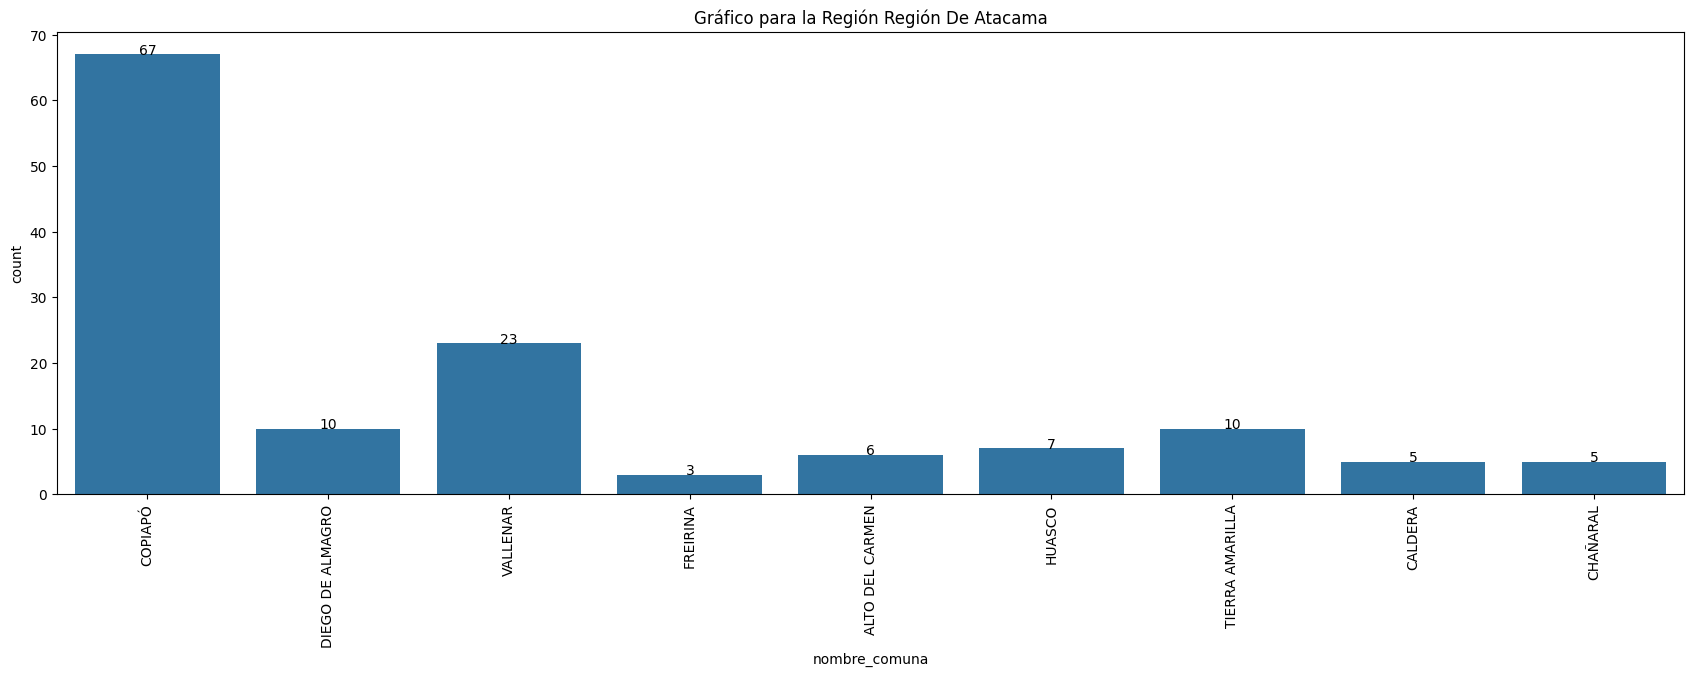

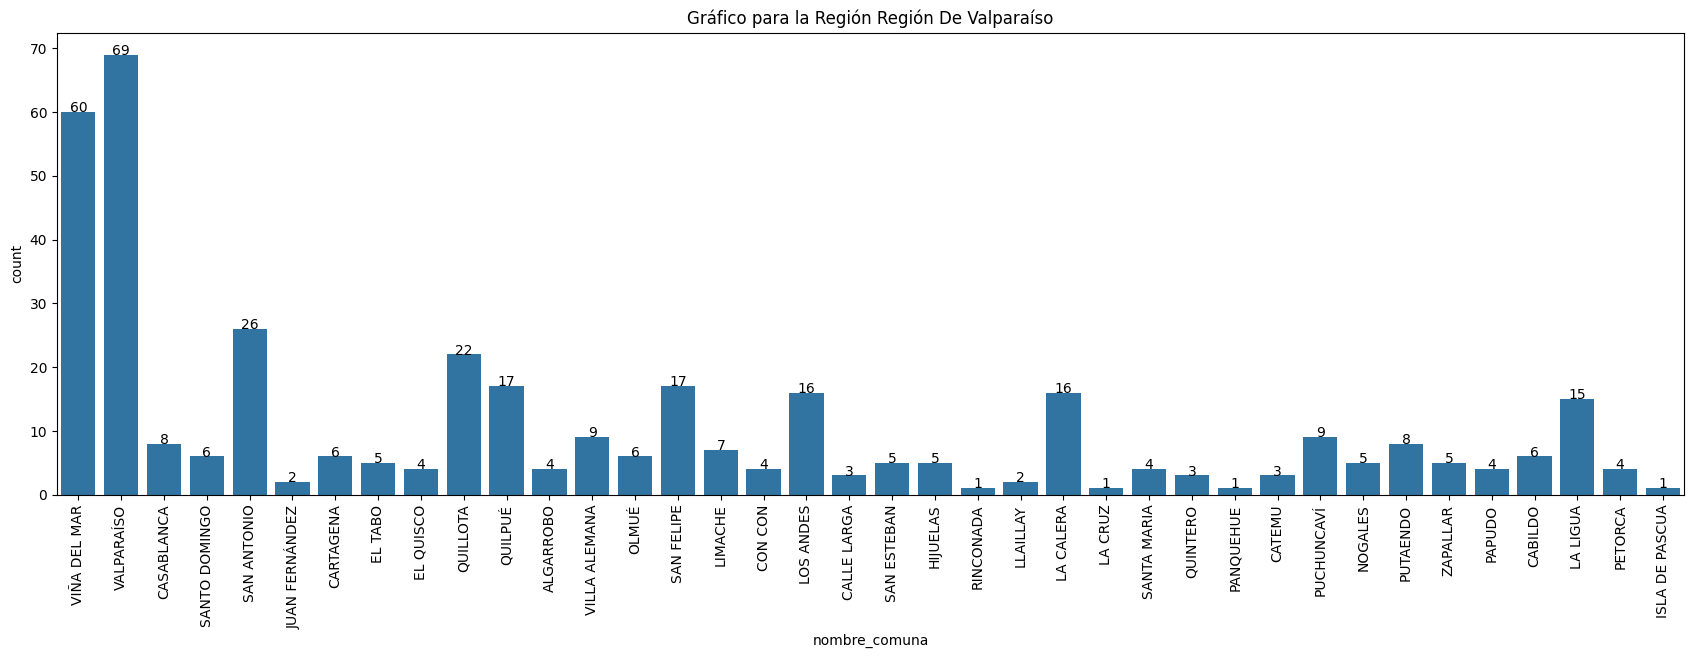

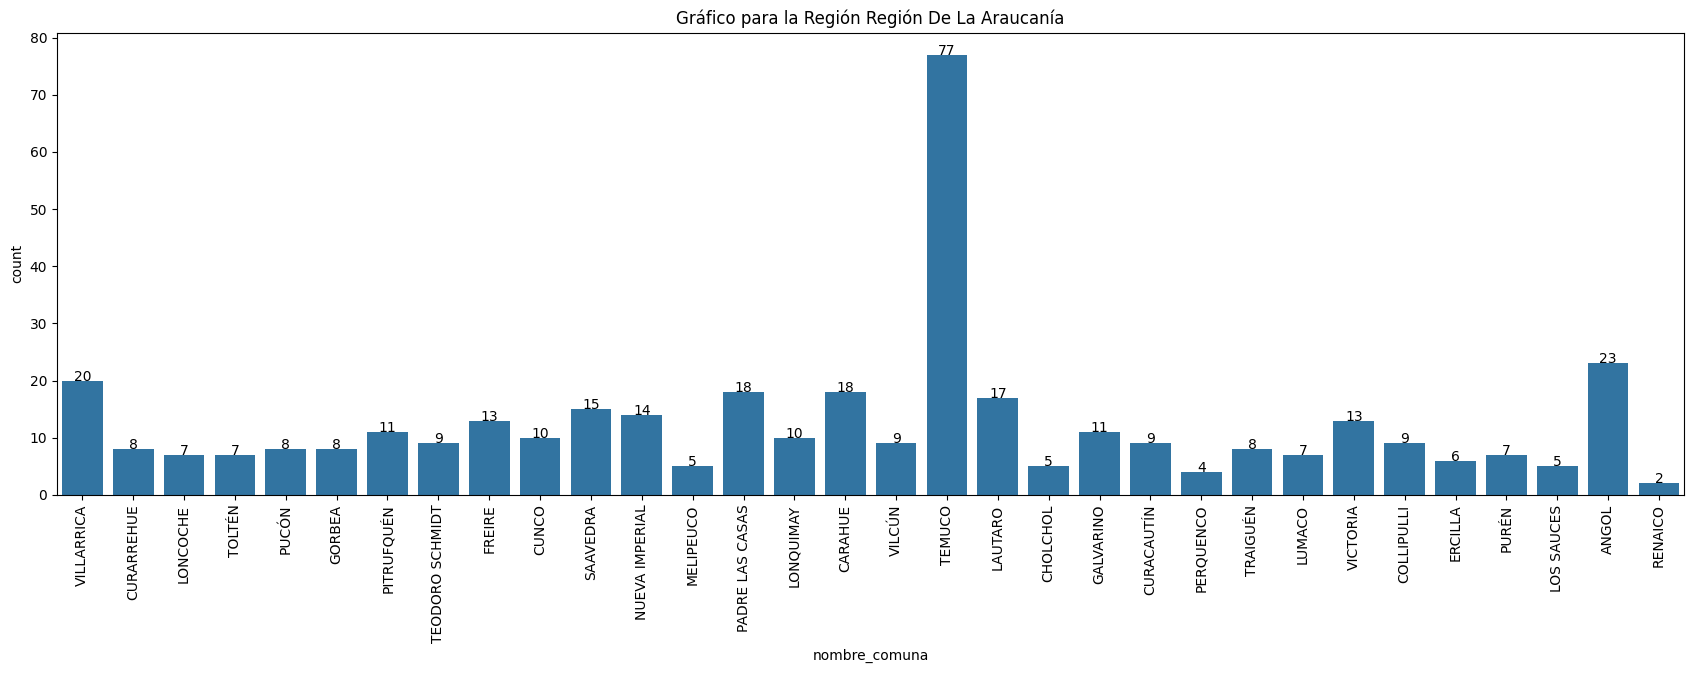

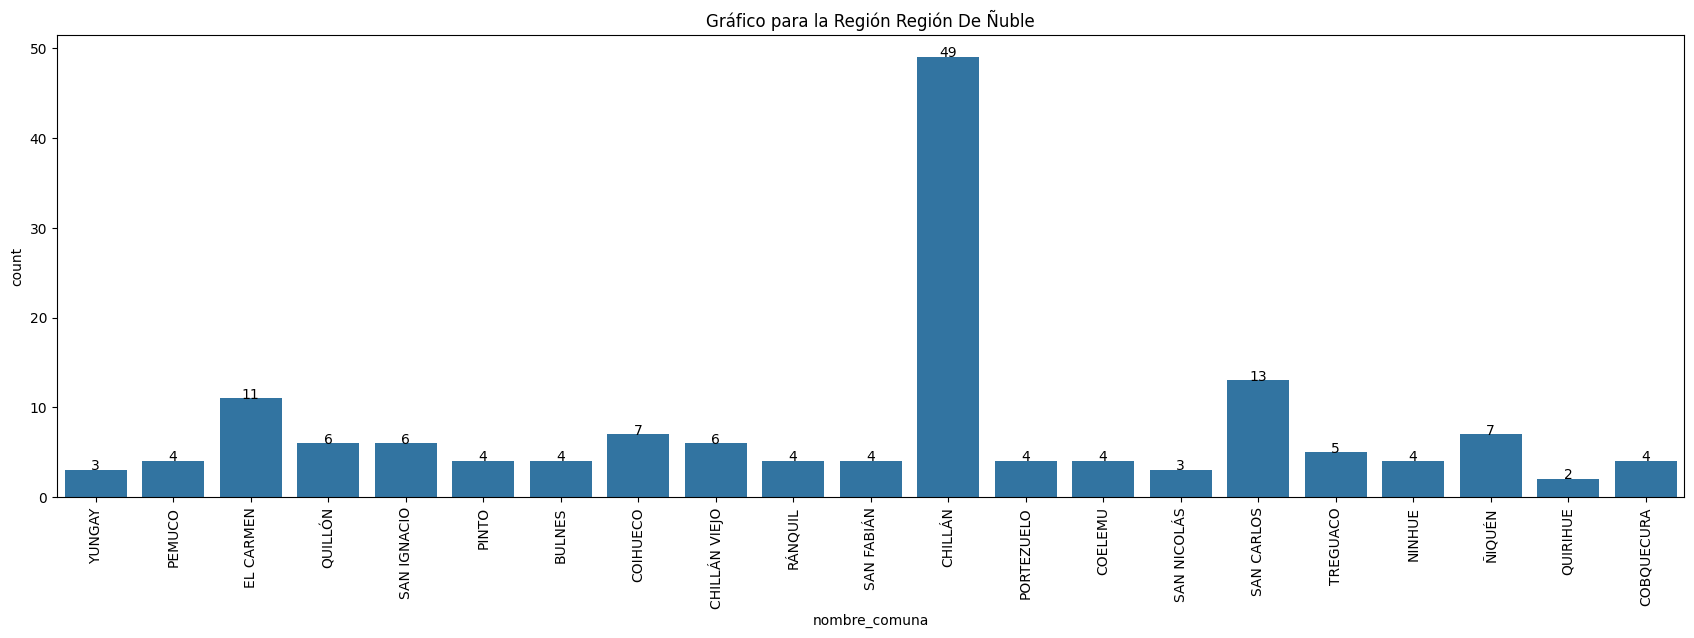

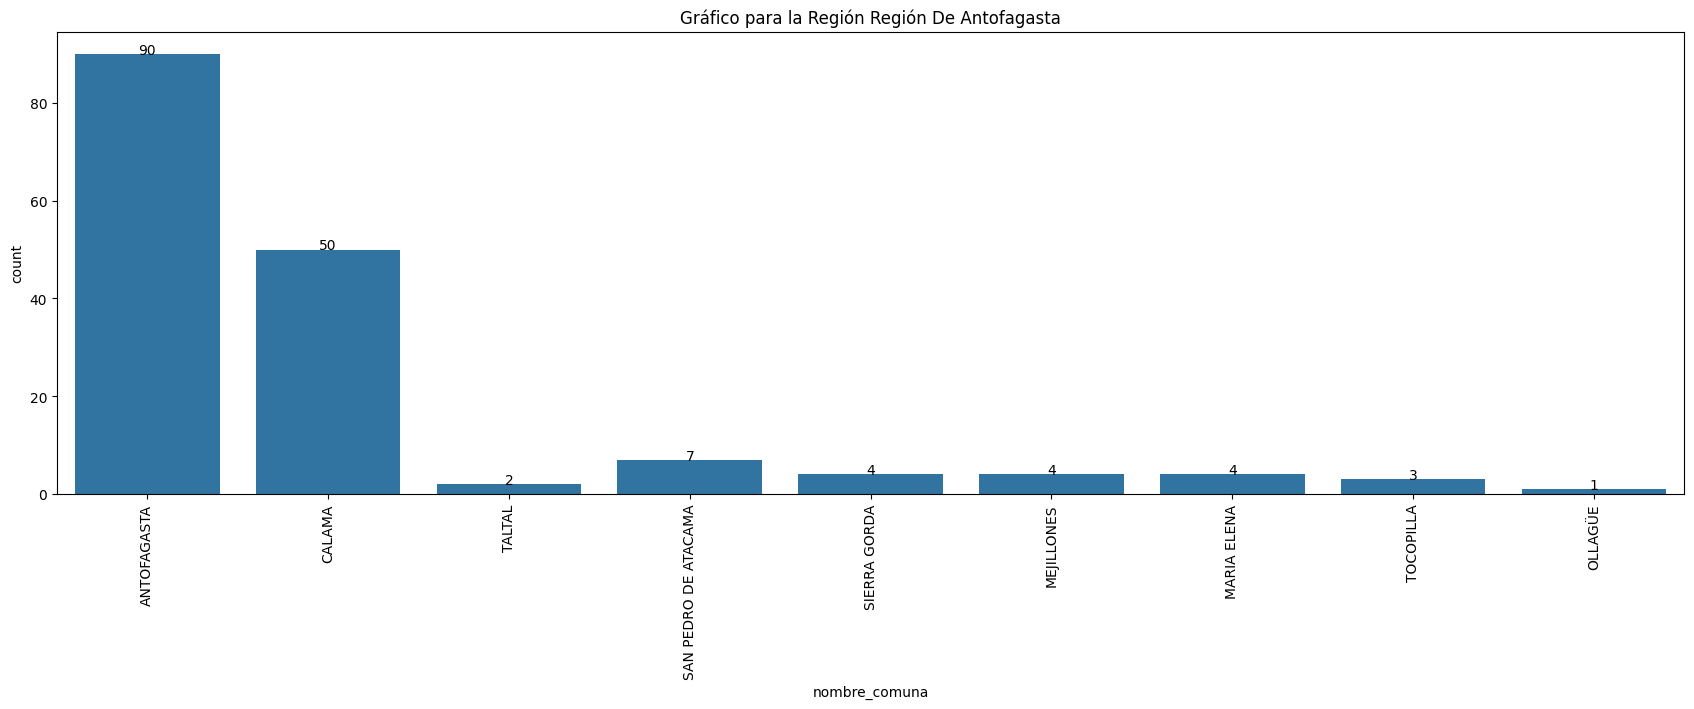

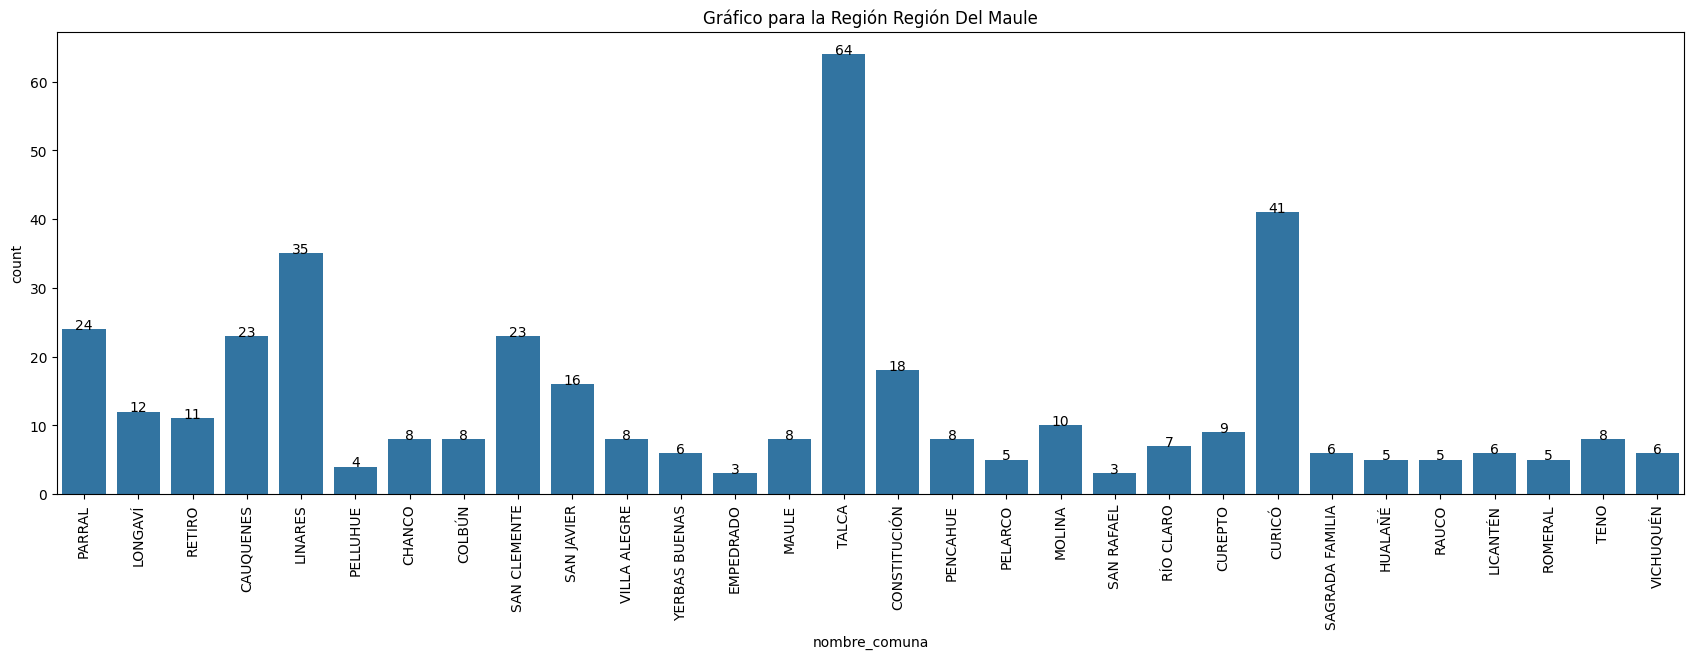

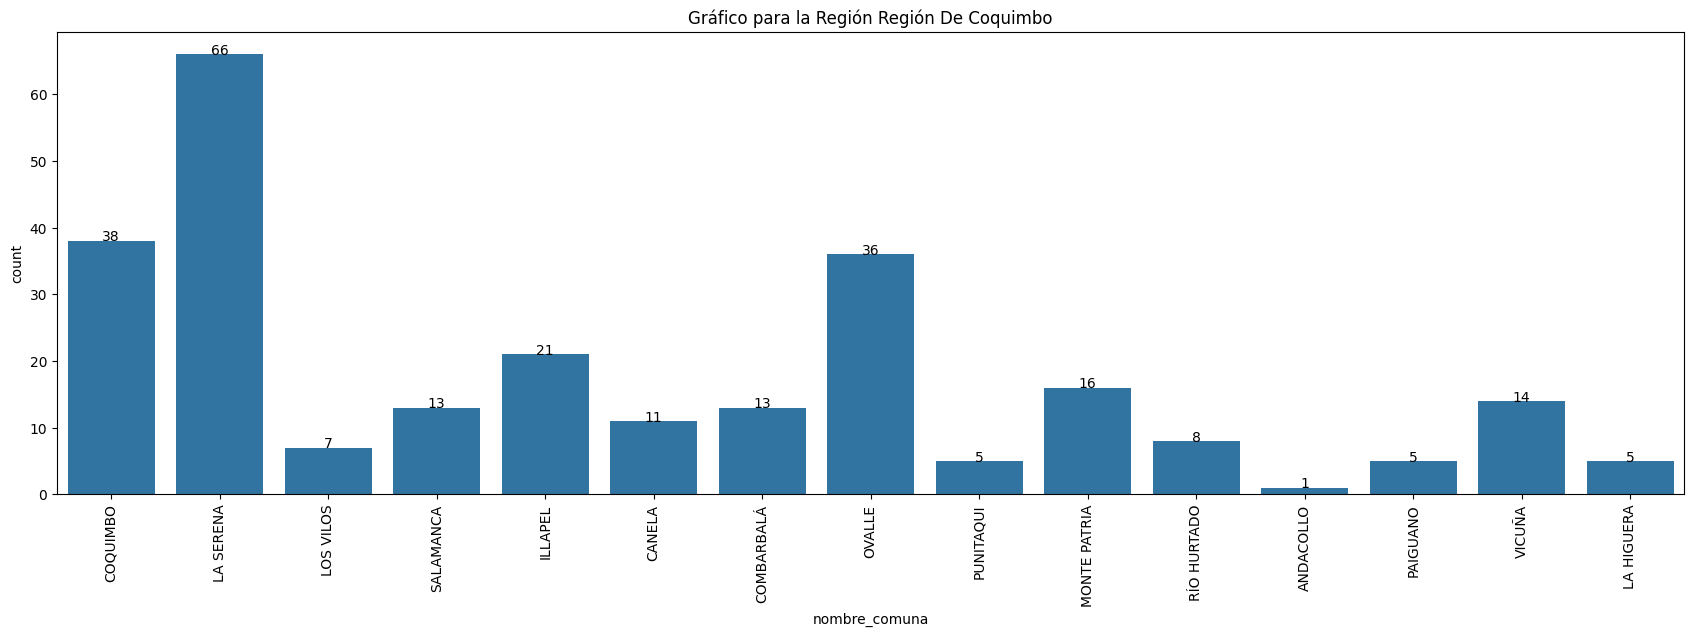

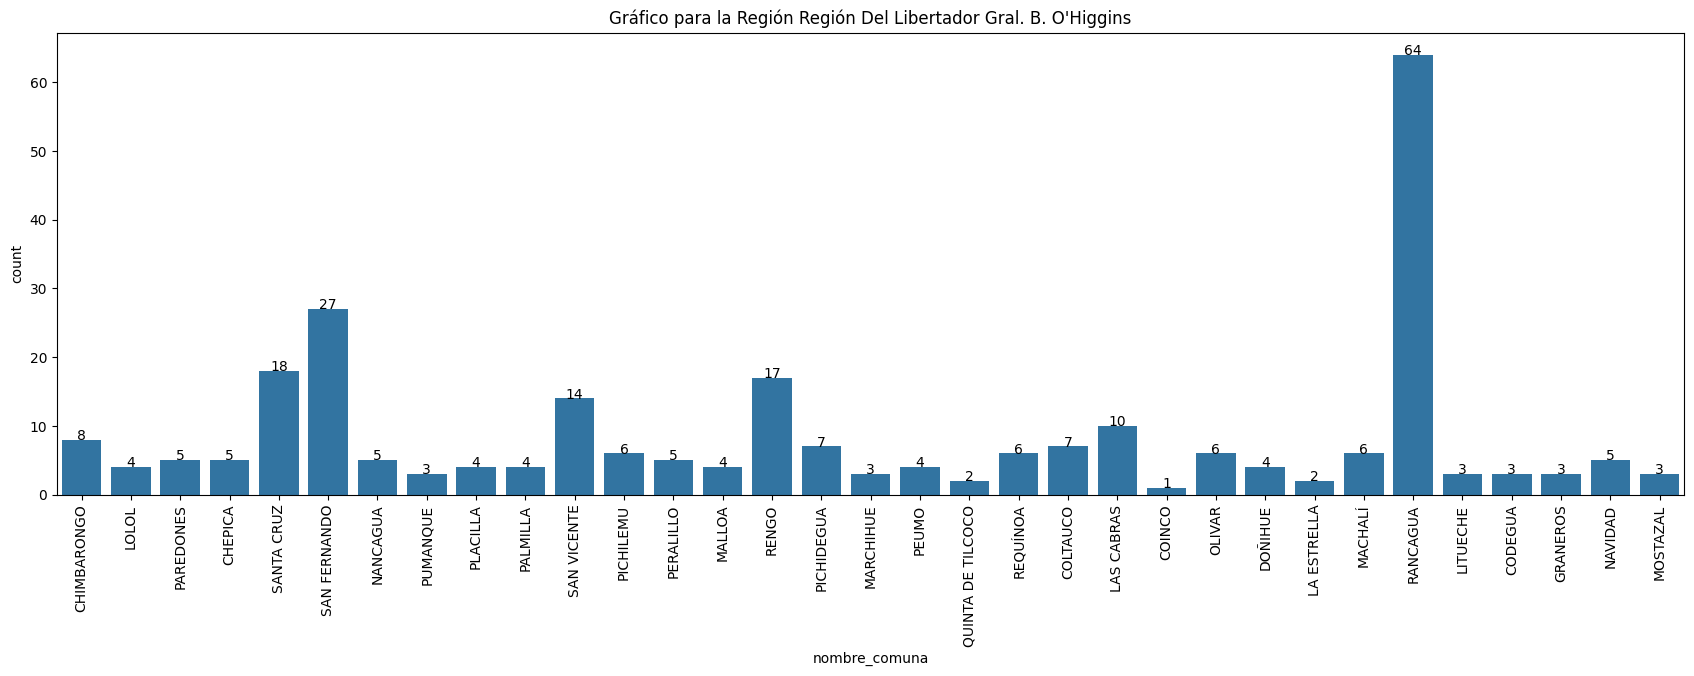

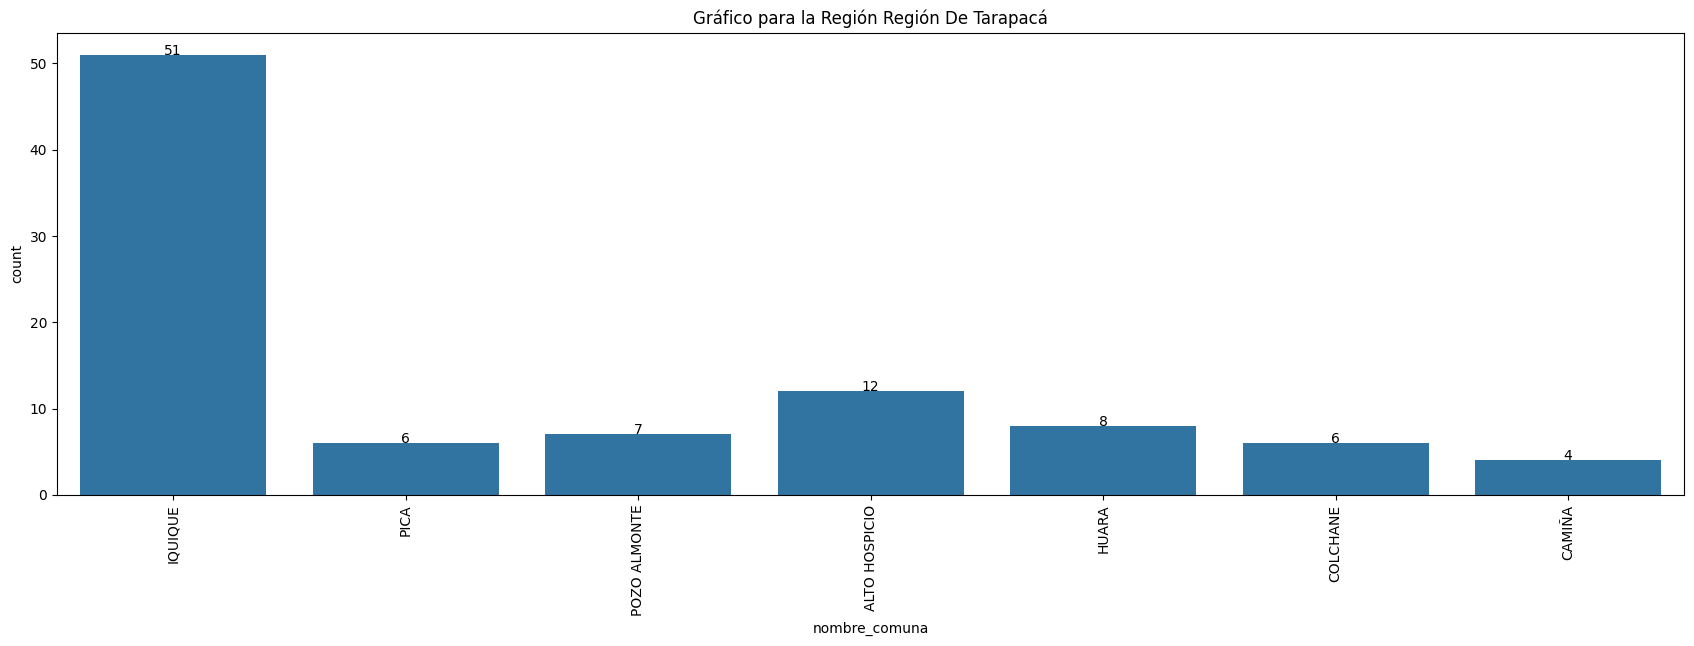

In [18]:
regiones_unicas = df_hospitales_1['nombre_región'].unique()

# Establece el tamaño de la figura
plt.figure(figsize=(21, 6))

# Itera a través de las regiones y crea un gráfico para cada una
for region in regiones_unicas:
    plt.figure(figsize=(21, 6))
    ax = sns.countplot(x="nombre_comuna", data=df_hospitales_1[df_hospitales_1['nombre_región'] == region])
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    plt.title(f'Gráfico para la Región {region}')
    plt.xticks(rotation=90)
    plt.show()

# Relacion entre poblacion y cantidad de hospitales

In [55]:
df_hospitales_poblacion_region = pd.merge(on="código_región", left=df_hospitales_1, right=df_poblacion_por_region)
conteo = df_hospitales_poblacion_region['código_región'].value_counts()
df_hospitales_poblacion_region['hospitales_x_region'] = df_hospitales_poblacion_region['código_región'].map(conteo)
df_hospitales_poblacion_region.drop_duplicates(subset="código_región", inplace=True)


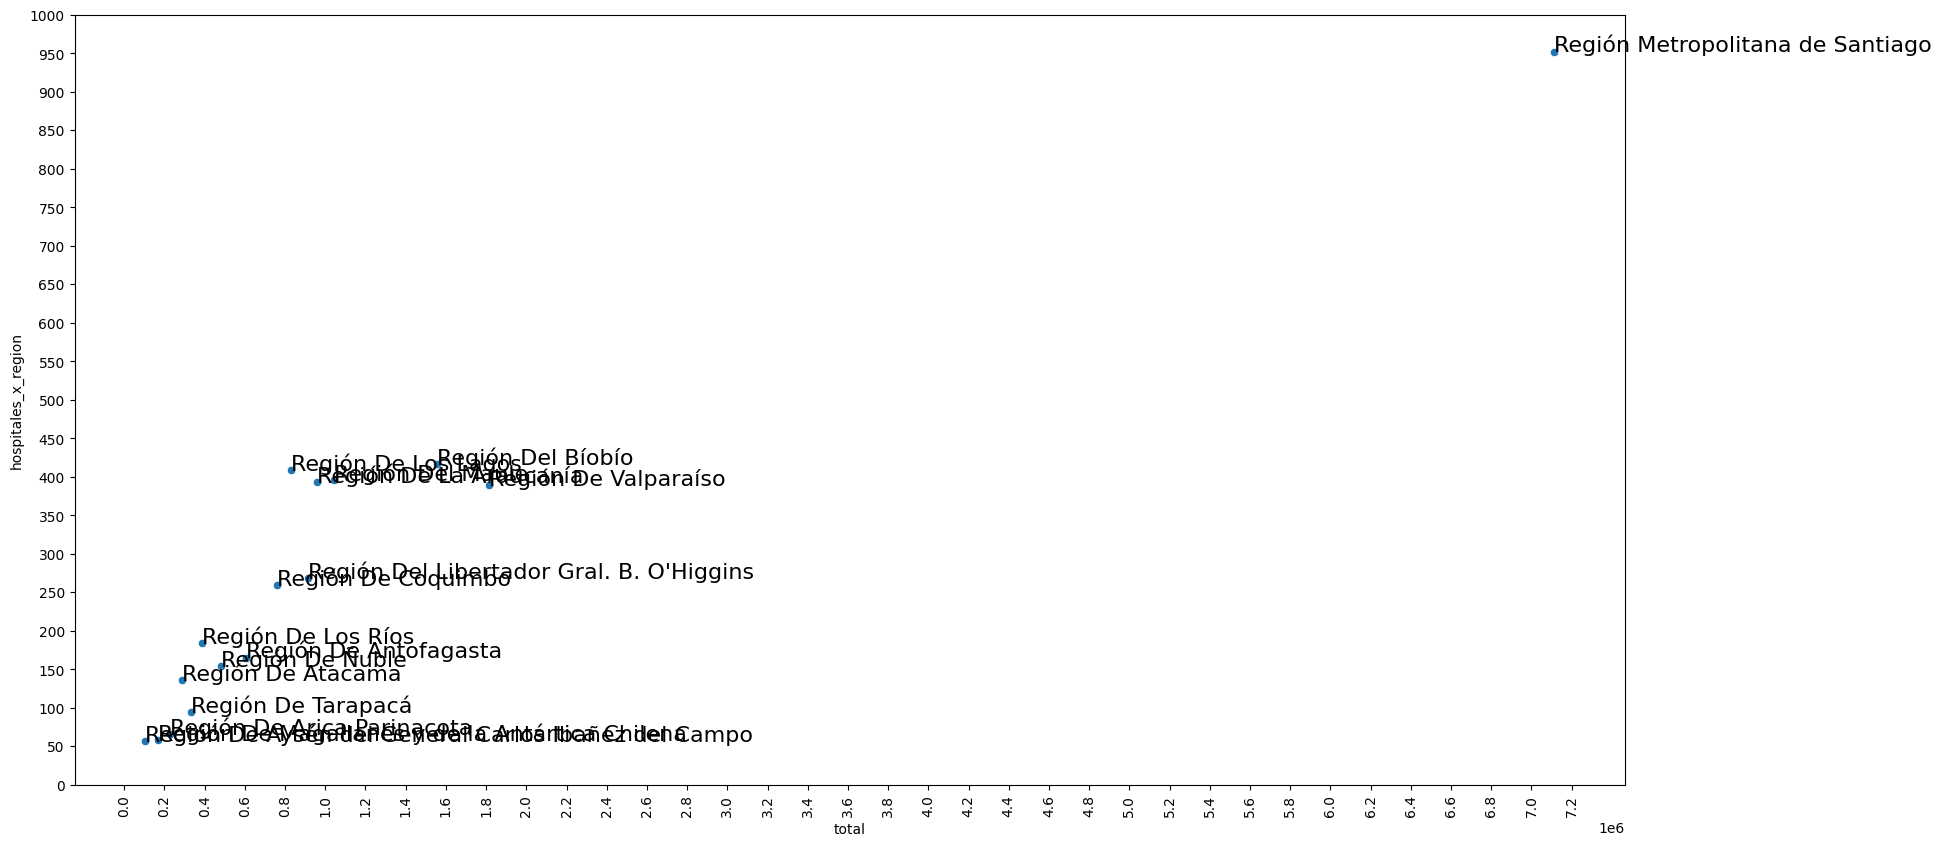

In [57]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_region["total"], y=df_hospitales_poblacion_region["hospitales_x_region"])

for i, txt in enumerate(df_hospitales_poblacion_region["nombre_región"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_region["total"].iloc[i], df_hospitales_poblacion_region["hospitales_x_region"].iloc[i]), fontsize=16)

#plt.yticks(range(0, max(df_hospitales_poblacion_region["hospitales_x_region"]) + 50000, 50000))
plt.yticks(range(0, max(df_hospitales_poblacion_region["hospitales_x_region"]) + 50, 50))
plt.xticks(range(0, max(df_hospitales_poblacion_region["total"]) + 100_000, 200_000), rotation=90)

plt.xticks(rotation=90)
plt.show()

In [58]:
df_hospitales_1.columns

Index(['código_vigente', 'código_región', 'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia'],
      dtype='object', name=0)

In [60]:
df_hospitales_poblacion_provincia = pd.merge(on="código_provincia", left=df_hospitales_1, right=df_poblacion_por_provincia)
conteo = df_hospitales_poblacion_provincia['código_provincia'].value_counts()
df_hospitales_poblacion_provincia['hospitales_x_provincia'] = df_hospitales_poblacion_provincia['código_provincia'].map(conteo)
df_hospitales_poblacion_provincia.drop_duplicates(subset="código_provincia", inplace=True)
df_hospitales_poblacion_provincia.head(1)

código_vigente  código_región  \
0          126704             12   

                                    nombre_región  \
0  Región De Magallanes y de la Antártica Chilena   

   código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                               26.0            

  nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                       Servicio de Salud Magallanes           

   pertenencia_al_snss tipo_establecimiento_(unidad)  \
0                 True                      Hospital   

   ámbito_de_funcionamiento  \
0  Establecimiento de Salud   

                                      nombre_oficial nivel_de_atención  ...  \
0  Hospital Comunitario Cristina Calderón de Puer...          Primario  ...   

    longitud tipo_de_prestador_sistema_de_salud  nivel_de_complejidad  \
0 -67.600393                           Público       Baja Complejidad   

                tipo_de_atención  código_provincia   nombre_provincia hombres  \
0  Atención Cerrada-Hospitalaria               122  ANTÁRTICA CHILENA    1321   

  mujeres total  hospitales_x_provincia  
0     880  2201                       2  

[1 rows x 25 columns]

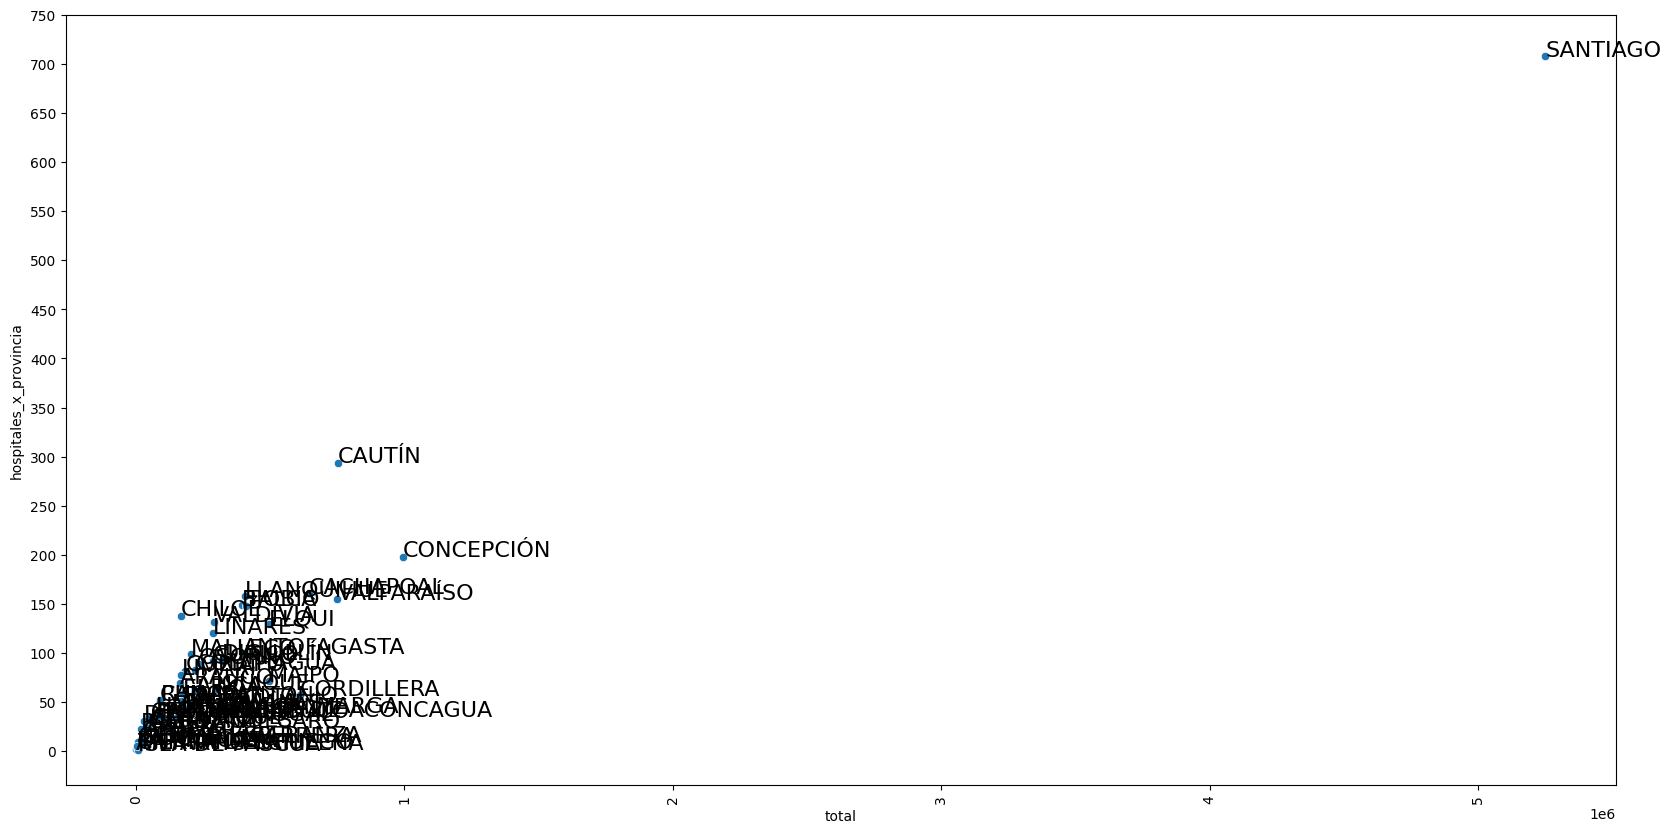

In [65]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_provincia["total"], y=df_hospitales_poblacion_provincia["hospitales_x_provincia"])

for i, txt in enumerate(df_hospitales_poblacion_provincia["nombre_provincia"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_provincia["total"].iloc[i], df_hospitales_poblacion_provincia["hospitales_x_provincia"].iloc[i]), fontsize=16)

plt.yticks(range(0, max(df_hospitales_poblacion_provincia["hospitales_x_provincia"]) + 50, 50))

plt.xticks(rotation=90)
plt.show()

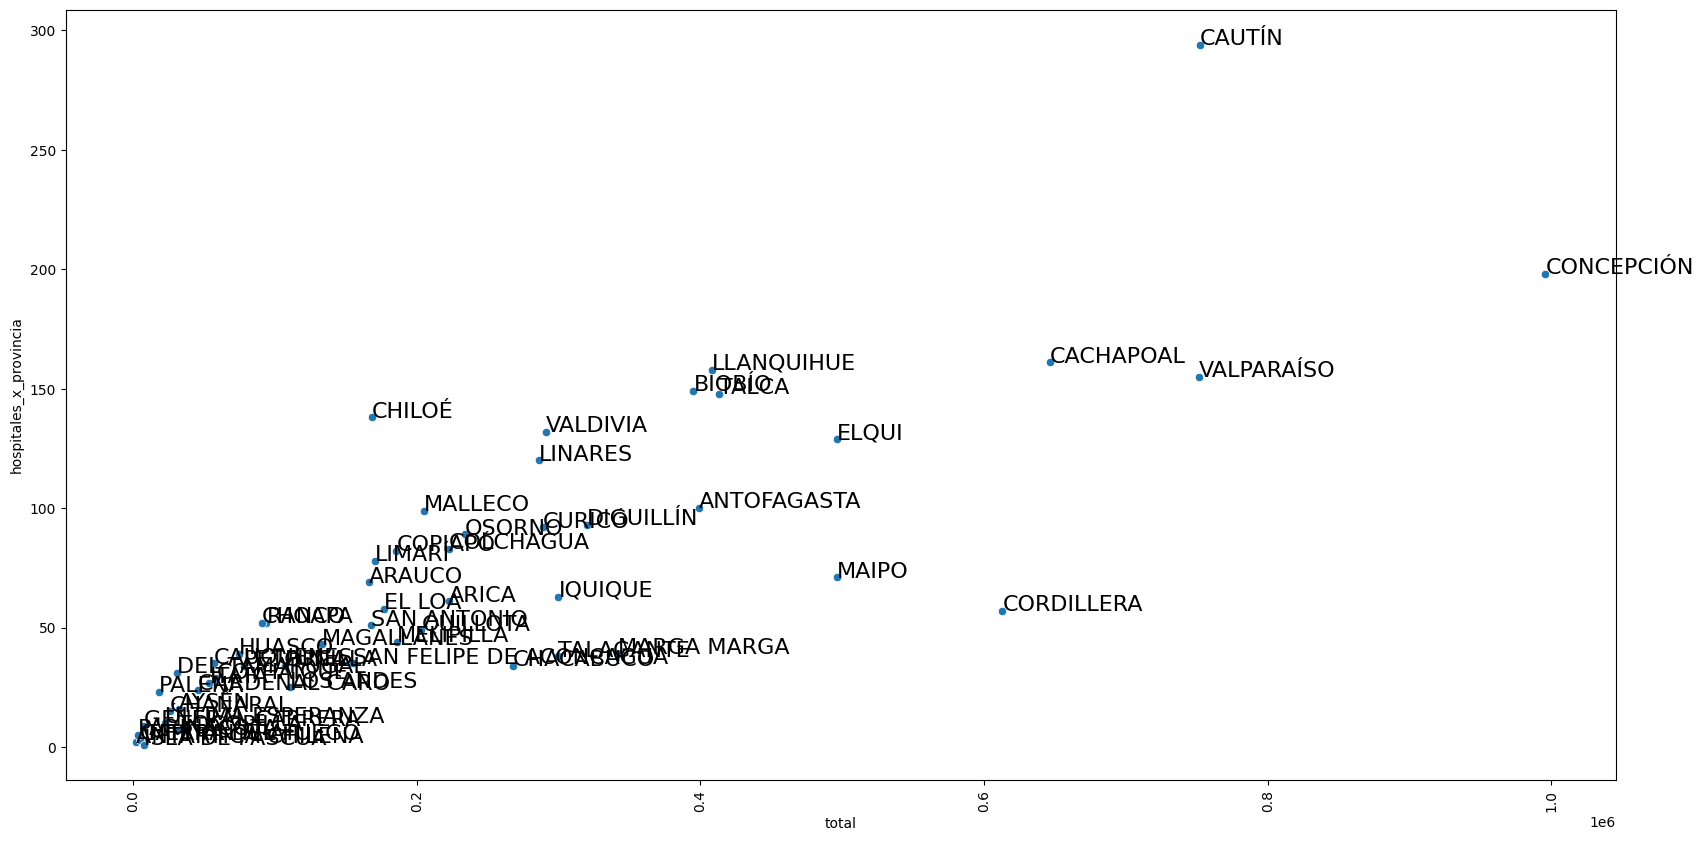

In [66]:
df_hospitales_poblacion_provincia = df_hospitales_poblacion_provincia[df_hospitales_poblacion_provincia["nombre_provincia"] != "SANTIAGO"]
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_provincia["total"], y=df_hospitales_poblacion_provincia["hospitales_x_provincia"])

for i, txt in enumerate(df_hospitales_poblacion_provincia["nombre_provincia"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_provincia["total"].iloc[i], df_hospitales_poblacion_provincia["hospitales_x_provincia"].iloc[i]), fontsize=16)

plt.yticks(range(0, max(df_hospitales_poblacion_provincia["hospitales_x_provincia"]) + 50, 50))

plt.xticks(rotation=90)
plt.show()

In [83]:
df_hospitales_poblacion_comuna = pd.merge(on="código_comuna", left=df_hospitales_1, right=df_poblacion_por_comuna)
conteo = df_hospitales_poblacion_comuna['código_comuna'].value_counts()
df_hospitales_poblacion_comuna['hospitales_x_comuna'] = df_hospitales_poblacion_comuna['código_comuna'].map(conteo)
df_hospitales_poblacion_comuna.drop_duplicates(subset="código_comuna", inplace=True)
df_hospitales_poblacion_comuna.head(1)

código_vigente  código_región  \
0          126704             12   

                                    nombre_región  \
0  Región De Magallanes y de la Antártica Chilena   

   código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                               26.0            

  nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                       Servicio de Salud Magallanes           

   pertenencia_al_snss tipo_establecimiento_(unidad)  \
0                 True                      Hospital   

   ámbito_de_funcionamiento  \
0  Establecimiento de Salud   

                                      nombre_oficial nivel_de_atención  ...  \
0  Hospital Comunitario Cristina Calderón de Puer...          Primario  ...   

    longitud tipo_de_prestador_sistema_de_salud  nivel_de_complejidad  \
0 -67.600393                           Público       Baja Complejidad   

                tipo_de_atención  código_provincia   nombre_provincia hombres  \
0  Atención Cerrada-Hospitalaria               122  ANTÁRTICA CHILENA    1195   

  mujeres total  hospitales_x_comuna  
0     868  2063                    2  

[1 rows x 25 columns]

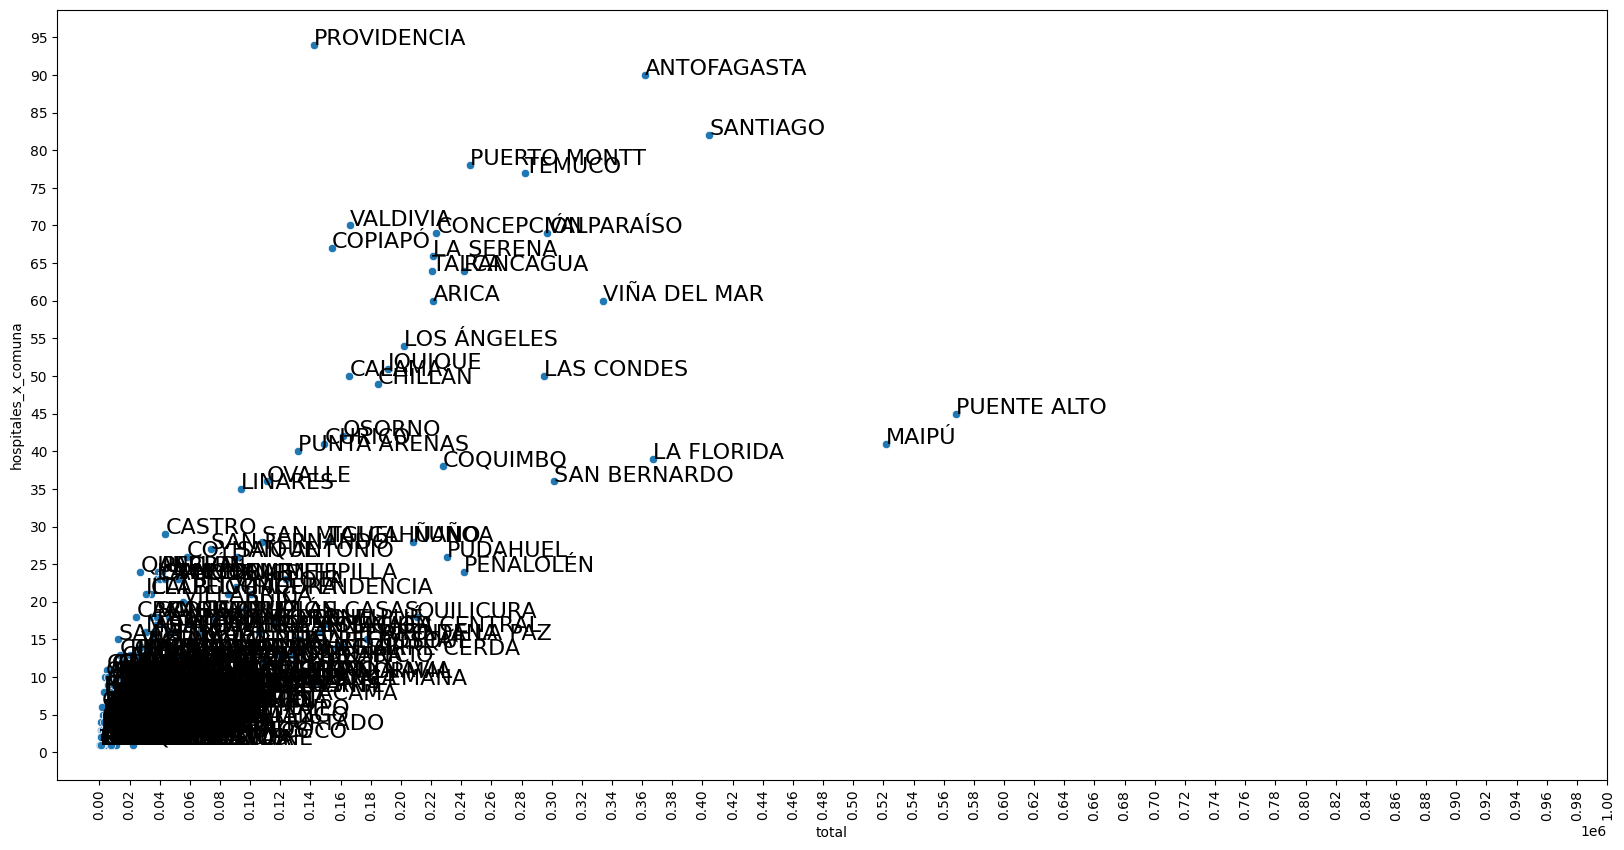

In [88]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_comuna["total"], y=df_hospitales_poblacion_comuna["hospitales_x_comuna"])

for i, txt in enumerate(df_hospitales_poblacion_comuna["nombre_comuna"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_comuna["total"].iloc[i], df_hospitales_poblacion_comuna["hospitales_x_comuna"].iloc[i]), fontsize=16)

plt.yticks(range(0, max(df_hospitales_poblacion_comuna["hospitales_x_comuna"]) + 5, 5))
plt.xticks(range(0, max(df_hospitales_poblacion_provincia["total"]) + 10_000, 20_000), rotation=90)

plt.xticks(rotation=90)
plt.show()

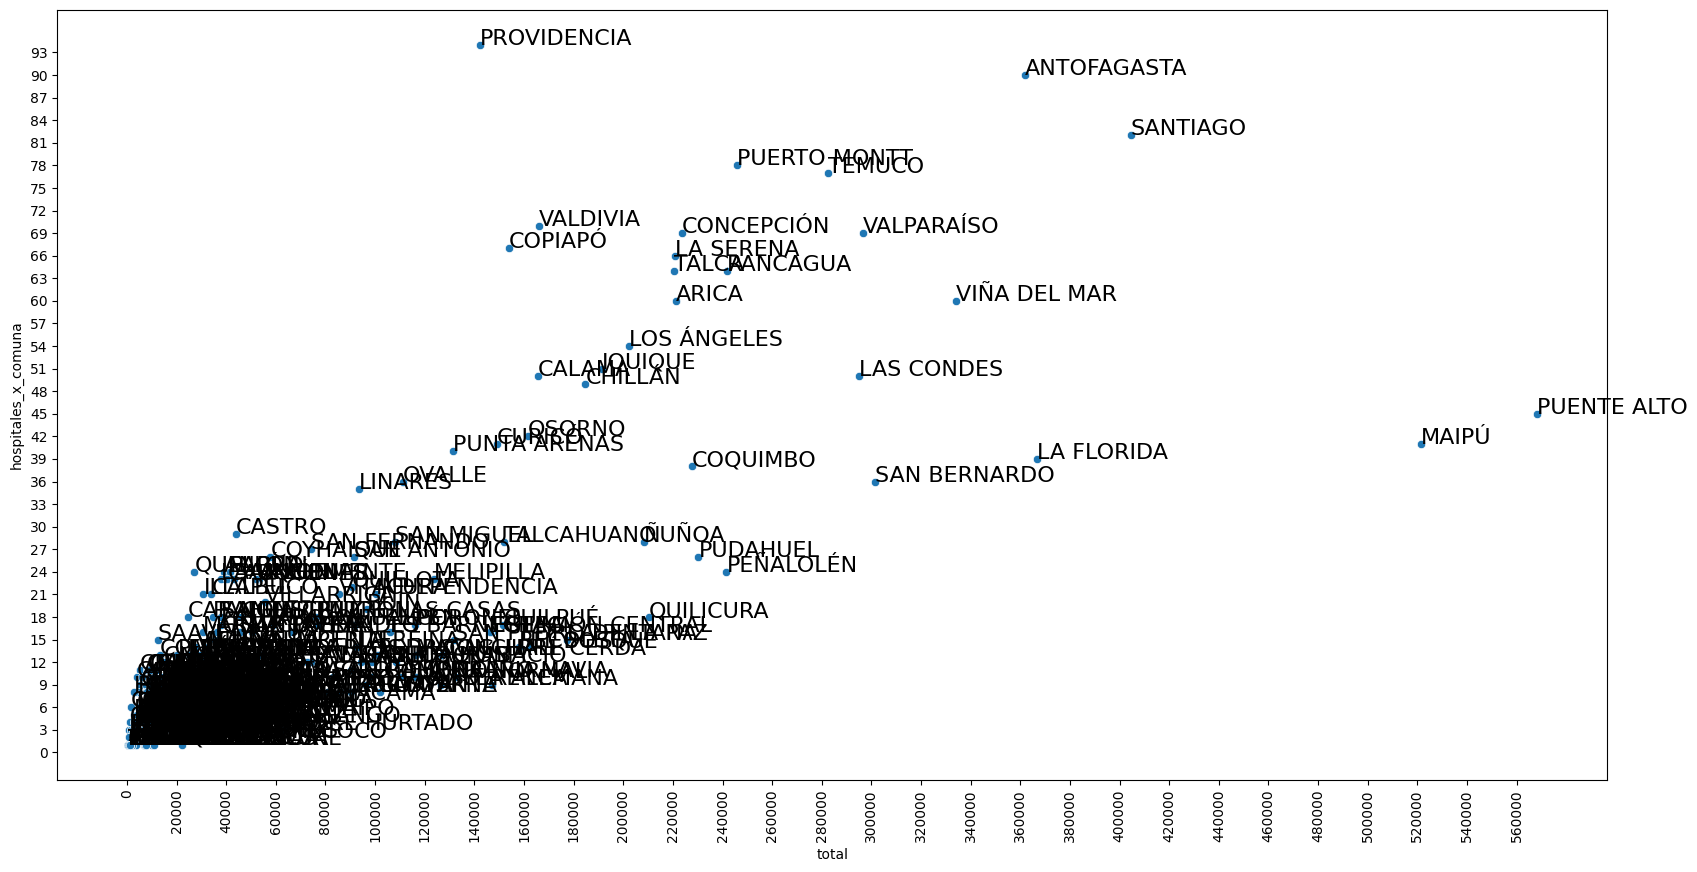

In [255]:
couta_inferior = 0
couta_superior = 10_000_000
df_hospitales_poblacion_comuna_2 = df_hospitales_poblacion_comuna[(couta_inferior <= df_hospitales_poblacion_comuna["total"]) & (df_hospitales_poblacion_comuna["total"] <= couta_superior)]
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_comuna_2["total"], y=df_hospitales_poblacion_comuna_2["hospitales_x_comuna"])

for i, txt in enumerate(df_hospitales_poblacion_comuna_2["nombre_comuna"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_comuna_2["total"].iloc[i], df_hospitales_poblacion_comuna_2["hospitales_x_comuna"].iloc[i]), fontsize=16)

plt.yticks(range(0, max(df_hospitales_poblacion_comuna_2["hospitales_x_comuna"]) + 1, 3))
plt.xticks(range(0, max(df_hospitales_poblacion_comuna_2["total"]) + 10_000, 20_000), rotation=90)

plt.xticks(rotation=90)
plt.show()

In [90]:
df_hospitales_poblacion_comuna.columns

Index(['código_vigente', 'código_región', 'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia', 'hombres',
       'mujeres', 'total', 'hospitales_x_comuna'],
      dtype='object')

In [93]:
df_hospitales_poblacion_comuna[["total", "hombres", "mujeres"]].corr()

total   hombres   mujeres
total    1.000000  0.999562  0.999612
hombres  0.999562  1.000000  0.998348
mujeres  0.999612  0.998348  1.000000

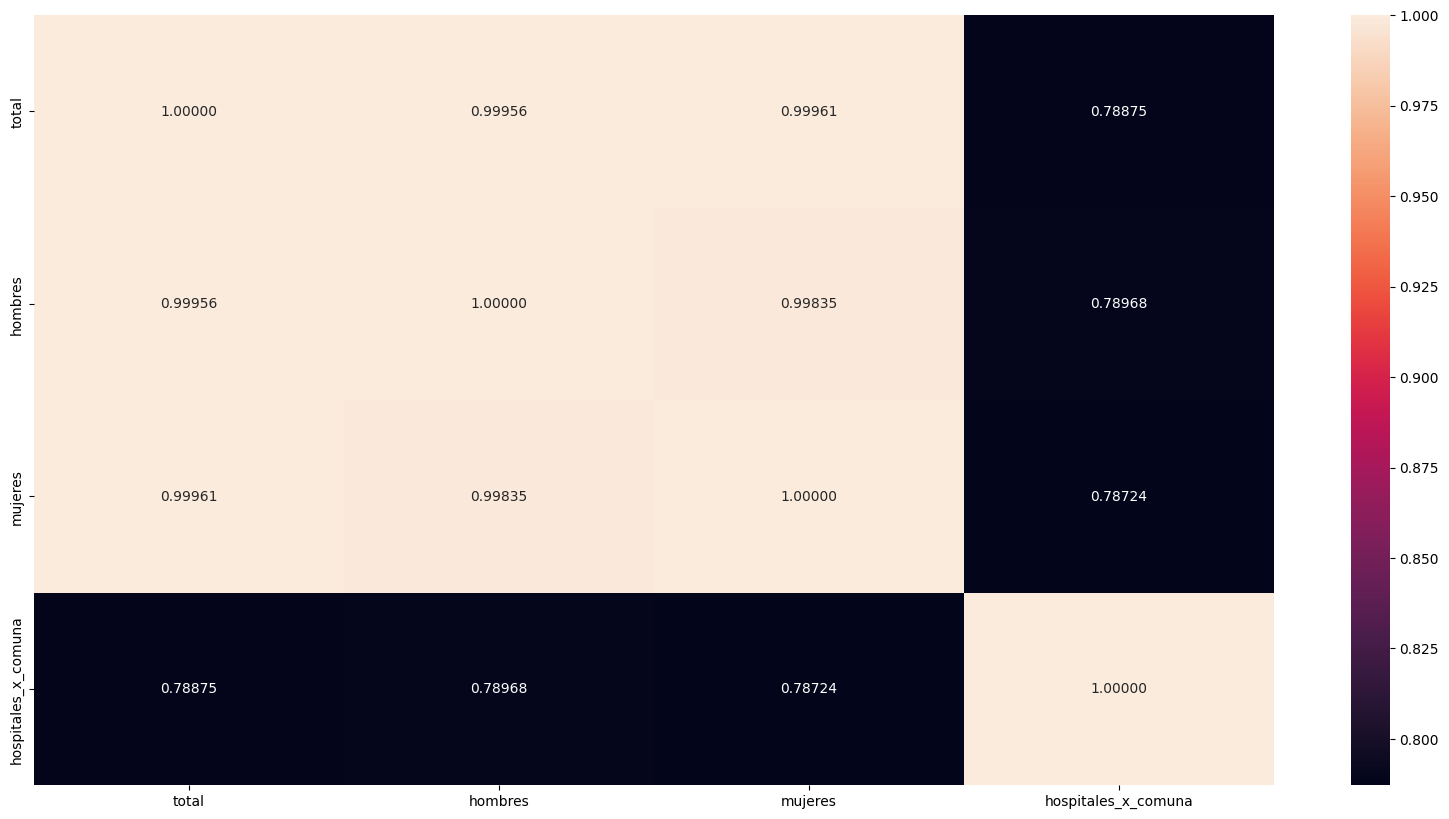

In [104]:
plt.figure(figsize=(20, 10))

correlation_matrix = df_hospitales_poblacion_comuna[["total", "hombres", "mujeres", "hospitales_x_comuna"]].corr().round(5)

sns.heatmap(correlation_matrix, annot=True,  fmt=".5f")

plt.show()

# Densidad centro de salud x cada 10.000 habitantes

In [208]:
df_km2 = pd.read_csv("../database/tabla_wikipedia.csv")
df_km2.drop(columns="Unnamed: 2", inplace=True)
nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_km2.columns}
df_km2.rename(columns=nuevos_nombres, inplace=True)
df_km2 = df_km2[["superficie_(km²)", "cut_(código_único_territorial)"]]
df_km2["superficie_(km²)"] = df_km2["superficie_(km²)"].str.replace(".", "").str.replace(",", ".").astype("float")
df_km2

superficie_(km²)  cut_(código_único_territorial)
0              4799.4                           15101
1              3927.0                           15102
2              5902.5                           15201
3              2244.4                           15202
4              2242.1                            1101
..                ...                             ...
341             126.0                           13601
342             118.0                           13602
343             189.0                           13603
344             808.0                           13604
345              69.0                           13605

[346 rows x 2 columns]

In [247]:
# df_hospitales_poblacion_comuna["densidad"] = df_hospitales_poblacion_comuna["hospitales_x_comuna"] / (df_hospitales_poblacion_comuna["total"] / 10_000)
df_hospitales_poblacion_comuna_densidad = df_hospitales_poblacion_comuna
df_hospitales_poblacion_comuna_densidad = pd.merge(left_on="código_comuna", right_on="cut_(código_único_territorial)",right=df_km2, left=df_hospitales_poblacion_comuna)
df_hospitales_poblacion_comuna_densidad["densidad_hospital_x_poblacion"] = df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"] / df_hospitales_poblacion_comuna_densidad["total"]
df_hospitales_poblacion_comuna_densidad["densidad_hospital_x_km2"] = df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"] / df_hospitales_poblacion_comuna_densidad["superficie_(km²)"]
df_hospitales_poblacion_comuna_densidad["densidad_poblacion"] =  df_hospitales_poblacion_comuna_densidad["total"] / df_hospitales_poblacion_comuna_densidad["superficie_(km²)"]
df_hospitales_poblacion_comuna_densidad["densidad_hospital_x_densidad_poblacional"] = (df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"] + df_hospitales_poblacion_comuna_densidad["densidad_poblacion"]) / 2
df_hospitales_poblacion_comuna_densidad

código_vigente  código_región  \
0            126704             12   
1            126412             12   
2            126414             12   
3            126102             12   
4            201364              8   
..              ...            ...   
340          102408              1   
341          101406             15   
342          101407             15   
343          101404             15   
344          201436             12   

                                      nombre_región  \
0    Región De Magallanes y de la Antártica Chilena   
1    Región De Magallanes y de la Antártica Chilena   
2    Región De Magallanes y de la Antártica Chilena   
3    Región De Magallanes y de la Antártica Chilena   
4                                 Región Del Bíobío   
..                                              ...   
340                              Región De Tarapacá   
341                      Región De Arica Parinacota   
342                      Región De Arica Parinacota   
343                      Región De Arica Parinacota   
344  Región De Magallanes y de la Antártica Chilena   

     código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                                 26.0            
1                                                 26.0            
2                                                 26.0            
3                                                 26.0            
4                                                  8.0            
..                                                 ...            
340                                                2.0            
341                                                1.0            
342                                                1.0            
343                                                1.0            
344                                               26.0            

    nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                         Servicio de Salud Magallanes           
1                         Servicio de Salud Magallanes           
2                         Servicio de Salud Magallanes           
3                         Servicio de Salud Magallanes           
4                                    SEREMI Del Biobío           
..                                                 ...           
340                         Servicio de Salud Tarapacá           
341               Servicio de Salud Arica y Parinacota           
342               Servicio de Salud Arica y Parinacota           
343               Servicio de Salud Arica y Parinacota           
344                       Servicio de Salud Magallanes           

     pertenencia_al_snss tipo_establecimiento_(unidad)  \
0                   True                      Hospital   
1                   True    Posta de Salud Rural (PSR)   
2                   True    Posta de Salud Rural (PSR)   
3                   True                      Hospital   
4                  False                Clínica Dental   
..                   ...                           ...   
340                 True    Posta de Salud Rural (PSR)   
341                 True    Posta de Salud Rural (PSR)   
342                 True    Posta de Salud Rural (PSR)   
343                 True    Posta de Salud Rural (PSR)   
344                 True    Posta de Salud Rural (PSR)   

     ámbito_de_funcionamiento  \
0    Establecimiento de Salud   
1    Establecimiento de Salud   
2    Establecimiento de Salud   
3    Establecimiento de Salud   
4    Establecimiento de Salud   
..                        ...   
340  Establecimiento de Salud   
341  Establecimiento de Salud   
342  Establecimiento de Salud   
343  Establecimiento de Salud   
344  Establecimiento de Salud   

                                        nombre_oficial nivel_de_atención  ...  \
0    Hospital Comunitario Cristina Calderón de Puer...          Primario  ...   
1                         Posta d

In [222]:
df_hospitales_poblacion_comuna_densidad.columns

Index(['código_vigente', 'código_región', 'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia', 'hombres',
       'mujeres', 'total', 'hospitales_x_comuna', 'superficie_(km²)',
       'cut_(código_único_territorial)', 'densidad_hospital_x_poblacion',
       'densidad_hospital_x_km2', 'densidad_hospital_x_densidad_poblacional'],
      dtype='object')

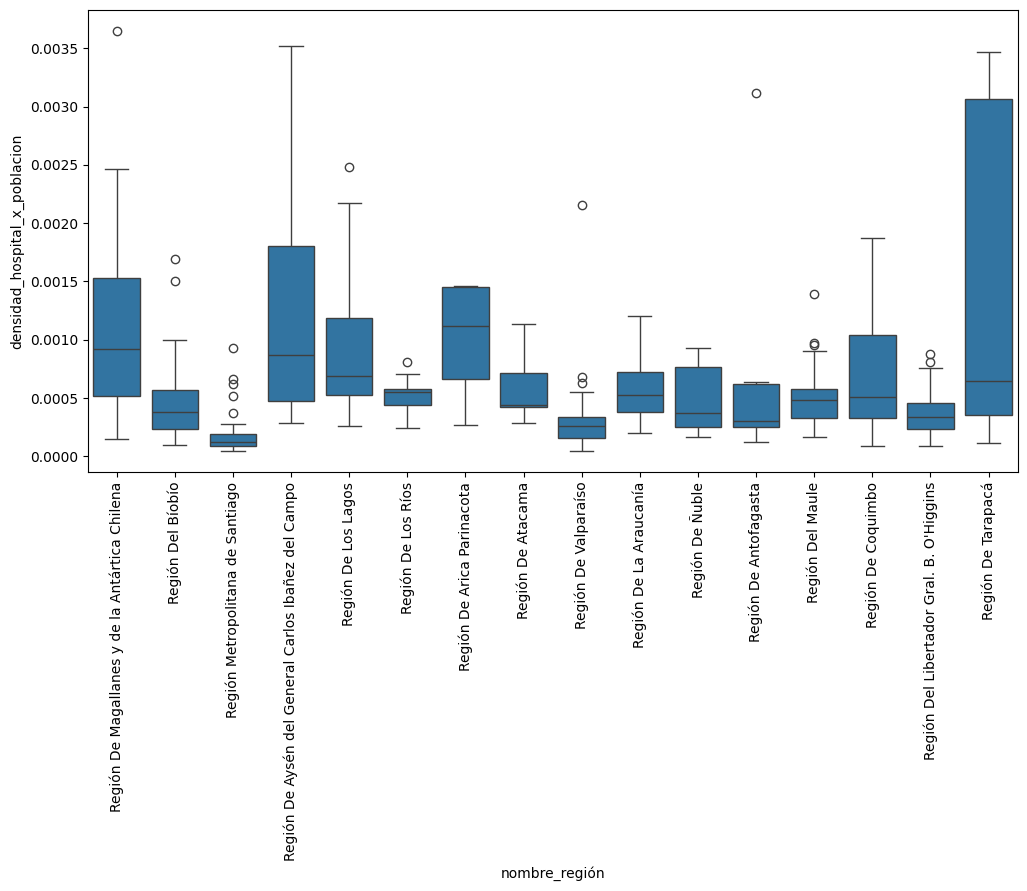

In [248]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_región", y="densidad_hospital_x_poblacion", data=df_hospitales_poblacion_comuna_densidad)
plt.xticks(rotation=90)
plt.show()

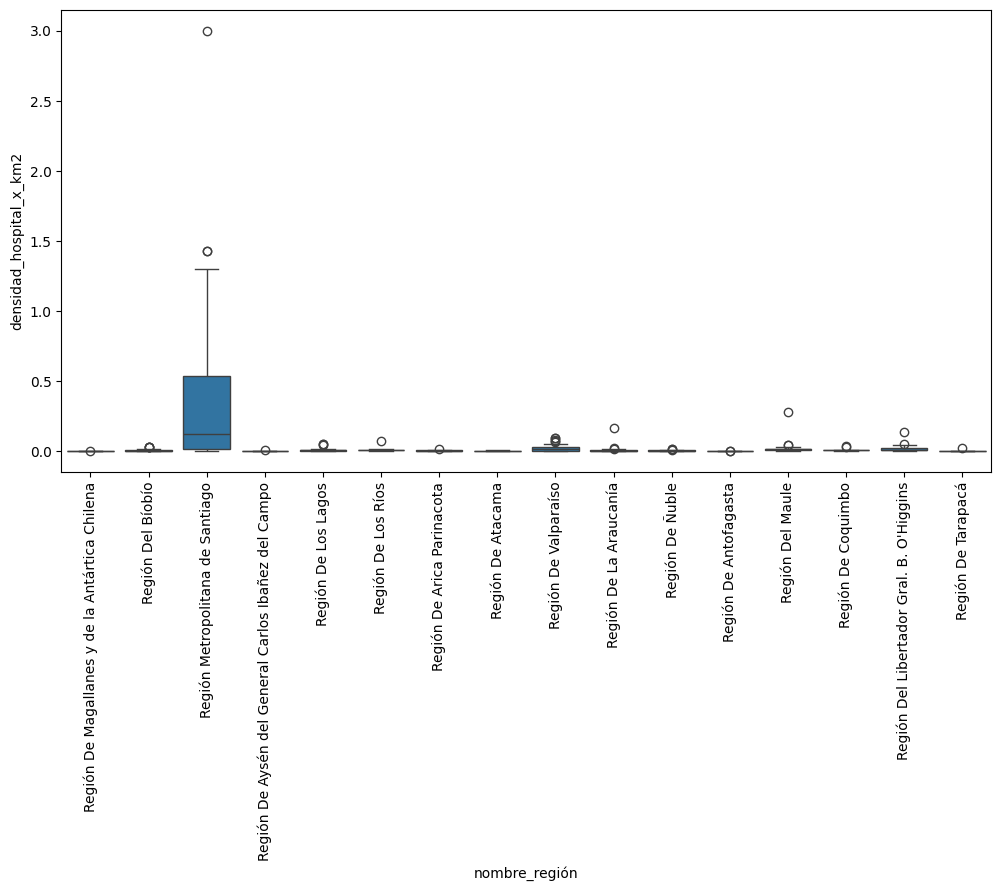

In [249]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_región", y="densidad_hospital_x_km2", data=df_hospitales_poblacion_comuna_densidad)
plt.xticks(rotation=90)
plt.show()

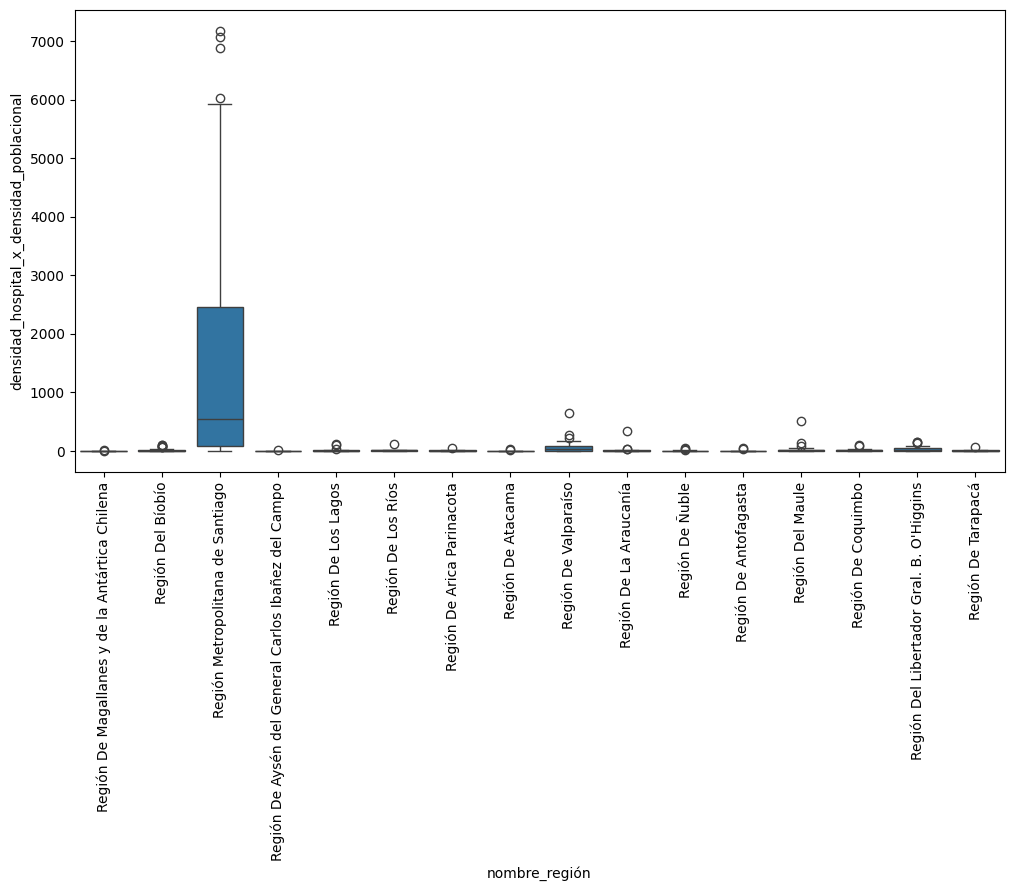

In [250]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_región", y="densidad_hospital_x_densidad_poblacional", data=df_hospitales_poblacion_comuna_densidad)
plt.xticks(rotation=90)
plt.show()

In [252]:
df_hospitales_poblacion_comuna_densidad.columns

Index(['código_vigente', 'código_región', 'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia', 'hombres',
       'mujeres', 'total', 'hospitales_x_comuna', 'superficie_(km²)',
       'cut_(código_único_territorial)', 'densidad_hospital_x_poblacion',
       'densidad_hospital_x_km2', 'densidad_poblacion',
       'densidad_hospital_x_densidad_poblacional'],
      dtype='object')

In [278]:
df_hospitales_poblacion_comuna_densidad.drop_duplicates(subset="nombre_comuna").sort_values(by="densidad_hospital_x_poblacion")[[
    "nombre_comuna", 
    "densidad_hospital_x_km2",
    "densidad_hospital_x_poblacion",
    "densidad_hospital_x_densidad_poblacional", 
    "total", 
    "hospitales_x_comuna", 
    "nombre_región", 
    "superficie_(km²)"]]

nombre_comuna  densidad_hospital_x_km2  densidad_hospital_x_poblacion  \
294        LA CRUZ                 0.012821                       0.000045   
247  PADRE HURTADO                 0.003713                       0.000047   
273          RENCA                 0.375000                       0.000061   
282  VILLA ALEMANA                 0.092784                       0.000071   
269    CERRO NAVIA                 0.909091                       0.000075   
..             ...                      ...                            ...   
334        OLLAGÜE                 0.000337                       0.003115   
340         CAMIÑA                 0.001818                       0.003200   
339       COLCHANE                 0.001494                       0.003472   
18      LAGO VERDE                 0.000553                       0.003521   
7    LAGUNA BLANCA                 0.000271                       0.003650   

     densidad_hospital_x_densidad_poblacional   total  hospitales_x_comuna  \
294                                142.153846   22098                    1   
247                                 40.639851   63250                    3   
273                               3070.145833  147151                    9   
282                                656.809278  126548                    9   
269                               6033.272727  132622                   10   
..                                        ...     ...                  ...   
334                                  0.554150     321                    1   
340                                  2.284065    1250                    4   
339                                  3.215161    1728                    6   
18                                   1.578564     852                    3   
7                                    0.537071     274                    1   

                                         nombre_región  superficie_(km²)  
294                               Región De Valparaíso              78.0  
247                   Región Metropolitana de Santiago             808.0  
273                   Región Metropolitana de Santiago              24.0  
282                               Región De Valparaíso              97.0  
269                   Región Metropolitana de Santiago              11.0  
..                                                 ...               ...  
334                              Región De Antofagasta            2964.0  
340                                 Región De Tarapacá            2200.2  
339                                 Región De Tarapacá            4015.6  
18   Región De Aysén del General Carlos Ibañez del ...            5422.3  
7       Región De Magallanes y de la Antártica Chilena            3695.6  

[345 rows x 8 columns]

TypeError: 'float' object cannot be interpreted as an integer

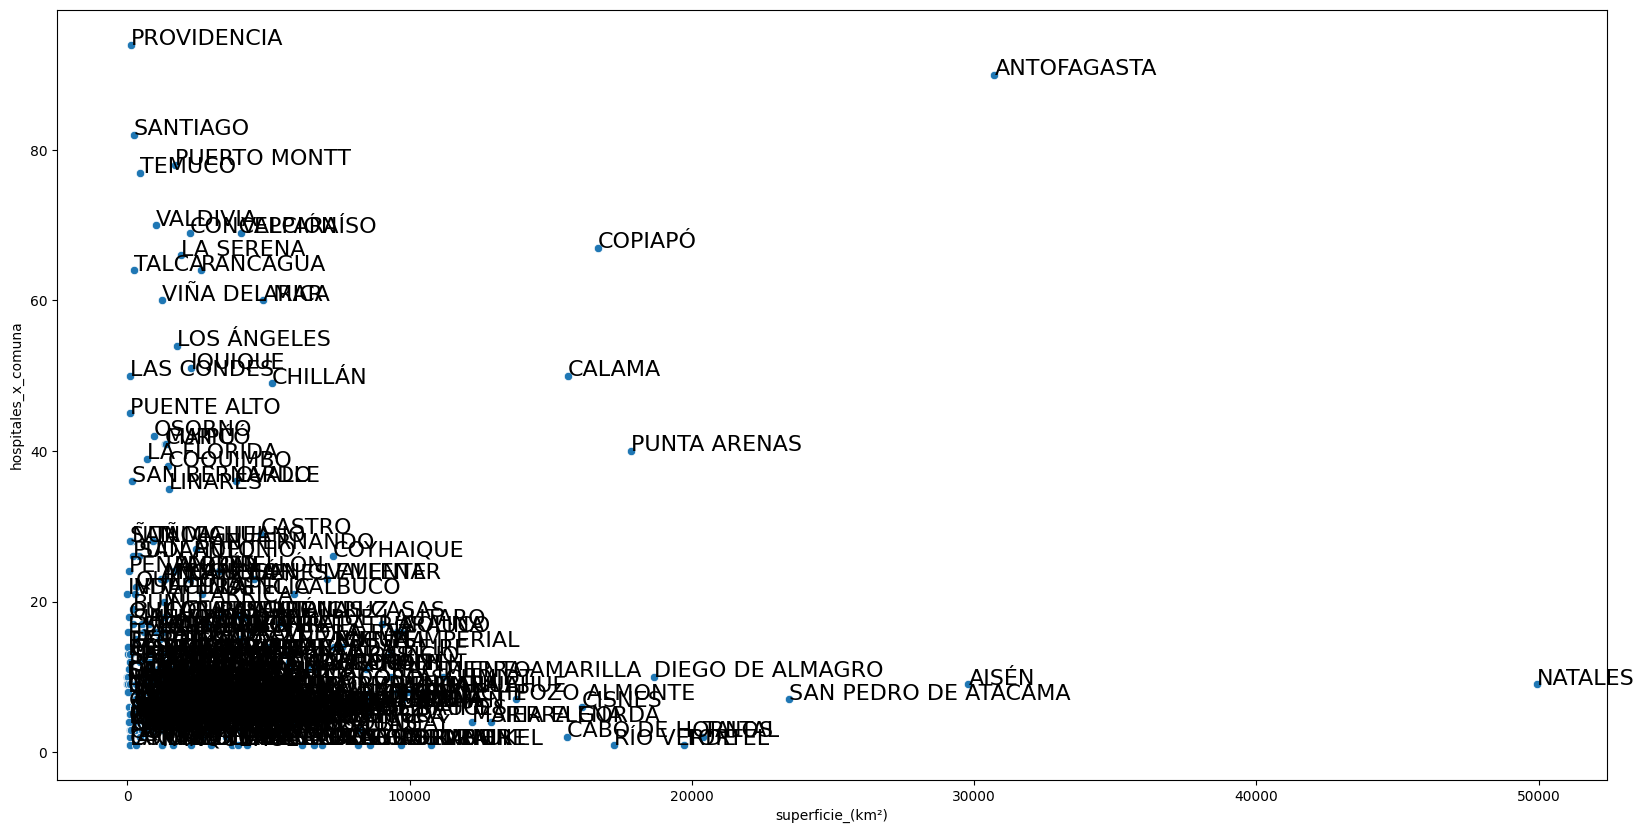

In [266]:

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_comuna_densidad["superficie_(km²)"], y=df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"])

for i, txt in enumerate(df_hospitales_poblacion_comuna_densidad["nombre_comuna"].unique()):
    ax.annotate(txt, (df_hospitales_poblacion_comuna_densidad["superficie_(km²)"].iloc[i], df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"].iloc[i]), fontsize=16)

plt.xticks(range(0, max(df_hospitales_poblacion_comuna_densidad["superficie_(km²)"]) + 10_000, 20_000), rotation=90)
plt.yticks(range(0, max(df_hospitales_poblacion_comuna_densidad["hospitales_x_comuna"]) + 1, 3))

plt.xticks(rotation=90)
plt.show()

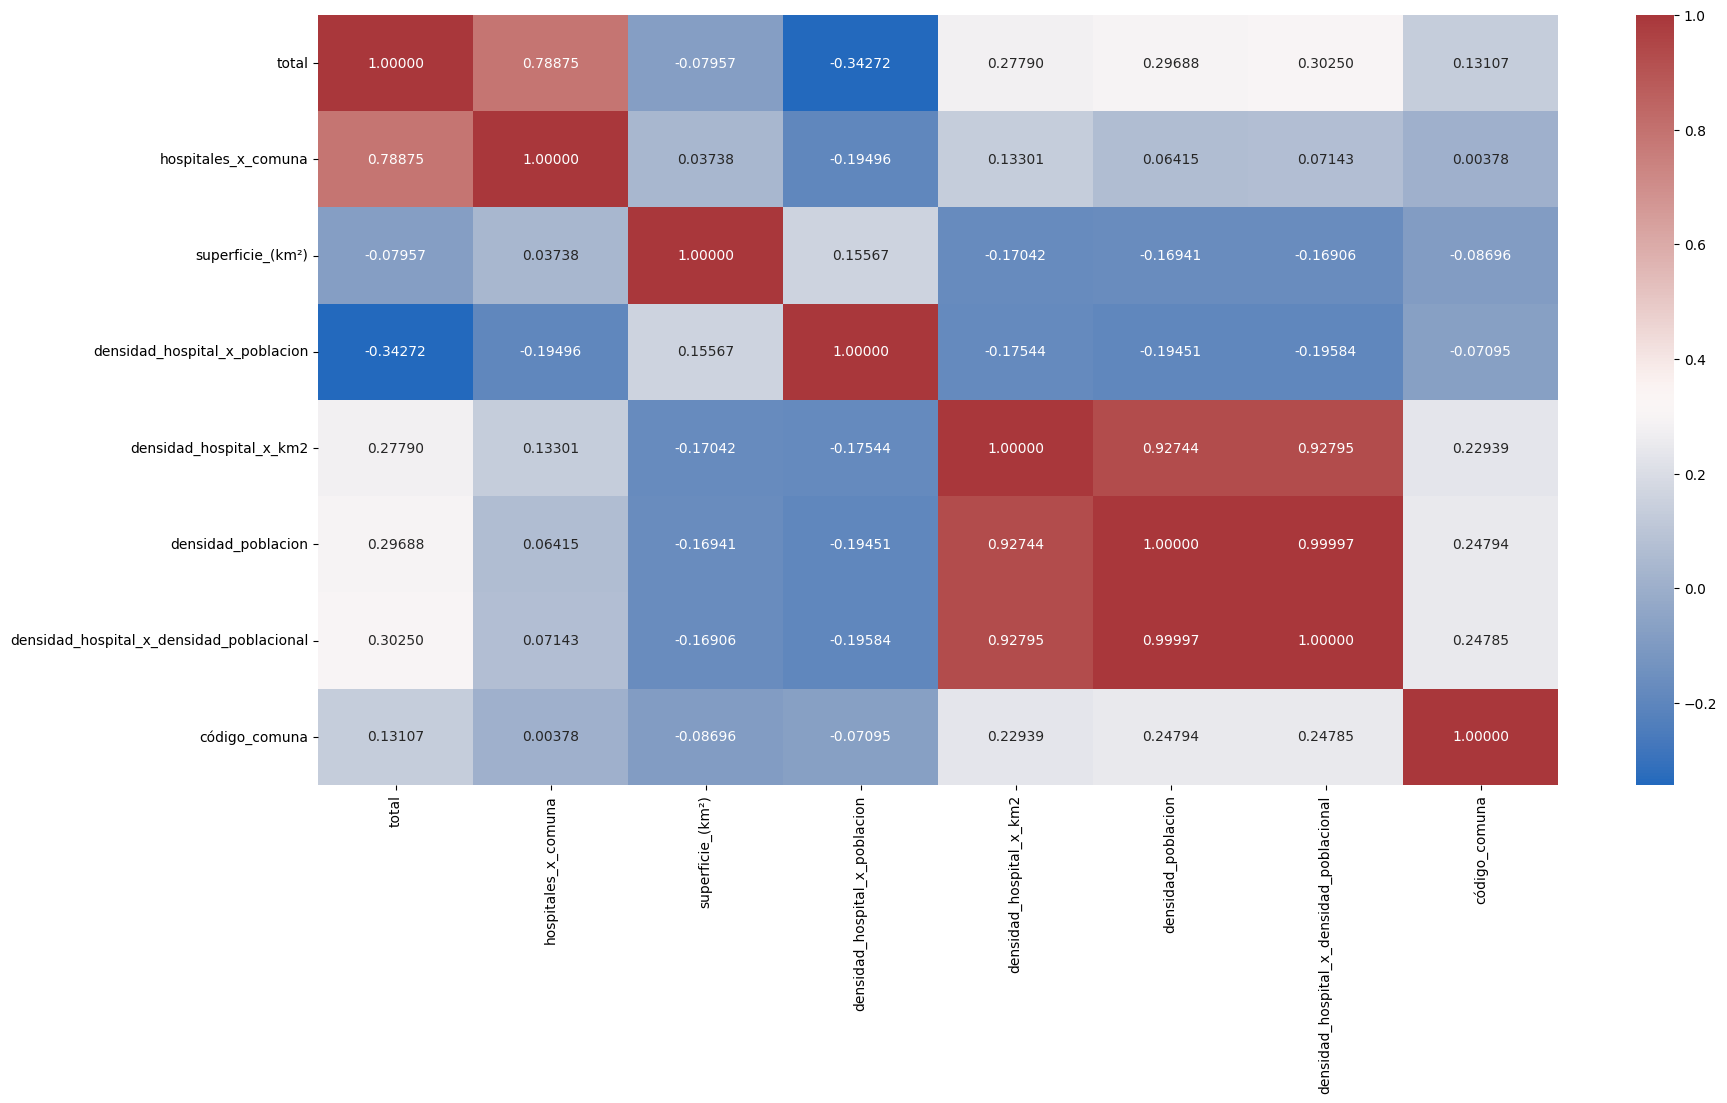

In [290]:
plt.figure(figsize=(20, 10))

df_hospitales_poblacion_comuna_densidad_numerico = df_hospitales_poblacion_comuna_densidad.select_dtypes(["number"])
df_hospitales_poblacion_comuna_densidad_numerico = df_hospitales_poblacion_comuna_densidad_numerico[
        ['total', 'hospitales_x_comuna', 'superficie_(km²)',
       'densidad_hospital_x_poblacion',
       'densidad_hospital_x_km2', 'densidad_poblacion',
       'densidad_hospital_x_densidad_poblacional',
       "código_comuna"]]
sns.heatmap(df_hospitales_poblacion_comuna_densidad_numerico.corr(), annot=True,  fmt=".5f", cmap="vlag")

plt.show()

In [299]:
gdf = gpd.read_file('../maps/Comunas.zip')


In [300]:
df_hospitales_poblacion_comuna_densidad

código_vigente  código_región  \
0            126704             12   
1            126412             12   
2            126414             12   
3            126102             12   
4            201364              8   
..              ...            ...   
340          102408              1   
341          101406             15   
342          101407             15   
343          101404             15   
344          201436             12   

                                      nombre_región  \
0    Región De Magallanes y de la Antártica Chilena   
1    Región De Magallanes y de la Antártica Chilena   
2    Región De Magallanes y de la Antártica Chilena   
3    Región De Magallanes y de la Antártica Chilena   
4                                 Región Del Bíobío   
..                                              ...   
340                              Región De Tarapacá   
341                      Región De Arica Parinacota   
342                      Región De Arica Parinacota   
343                      Región De Arica Parinacota   
344  Región De Magallanes y de la Antártica Chilena   

     código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                                 26.0            
1                                                 26.0            
2                                                 26.0            
3                                                 26.0            
4                                                  8.0            
..                                                 ...            
340                                                2.0            
341                                                1.0            
342                                                1.0            
343                                                1.0            
344                                               26.0            

    nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                         Servicio de Salud Magallanes           
1                         Servicio de Salud Magallanes           
2                         Servicio de Salud Magallanes           
3                         Servicio de Salud Magallanes           
4                                    SEREMI Del Biobío           
..                                                 ...           
340                         Servicio de Salud Tarapacá           
341               Servicio de Salud Arica y Parinacota           
342               Servicio de Salud Arica y Parinacota           
343               Servicio de Salud Arica y Parinacota           
344                       Servicio de Salud Magallanes           

     pertenencia_al_snss tipo_establecimiento_(unidad)  \
0                   True                      Hospital   
1                   True    Posta de Salud Rural (PSR)   
2                   True    Posta de Salud Rural (PSR)   
3                   True                      Hospital   
4                  False                Clínica Dental   
..                   ...                           ...   
340                 True    Posta de Salud Rural (PSR)   
341                 True    Posta de Salud Rural (PSR)   
342                 True    Posta de Salud Rural (PSR)   
343                 True    Posta de Salud Rural (PSR)   
344                 True    Posta de Salud Rural (PSR)   

     ámbito_de_funcionamiento  \
0    Establecimiento de Salud   
1    Establecimiento de Salud   
2    Establecimiento de Salud   
3    Establecimiento de Salud   
4    Establecimiento de Salud   
..                        ...   
340  Establecimiento de Salud   
341  Establecimiento de Salud   
342  Establecimiento de Salud   
343  Establecimiento de Salud   
344  Establecimiento de Salud   

                                        nombre_oficial nivel_de_atención  ...  \
0    Hospital Comunitario Cristina Calderón de Puer...          Primario  ...   
1                         Posta d

In [301]:
gdf = pd.merge(left=gdf, right=df_hospitales_poblacion_comuna_densidad, left_on="cod_comuna", right_on="código_comuna")
gdf

objectid     shape_leng  dis_elec  cir_sena  cod_comuna  codregion  \
0          48  170038.624165        16         8        6204          6   
1          29  125730.104795        15         8        6102          6   
2          30   63026.084422        15         8        6103          6   
3          31   89840.903562        15         8        6104          6   
4          78  122626.493264        23        11        9121          9   
..        ...            ...       ...       ...         ...        ...   
340       255  130240.555805        19        10       16305         16   
341       253  311061.932415        19        10       16304         16   
342       245  159257.906431        19        10       16303         16   
343       243  157467.049667        19        10       16104         16   
344       242  276848.826499        19        10       16302         16   

       st_area_sh     st_length_                                    Region  \
0    9.685774e+08  206184.271675  Región del Libertador Bernardo O'Higgins   
1    4.157446e+08  151911.576827  Región del Libertador Bernardo O'Higgins   
2    1.448565e+08   76355.326122  Región del Libertador Bernardo O'Higgins   
3    3.256572e+08  108874.623150  Región del Libertador Bernardo O'Higgins   
4    6.990727e+08  156680.410681                    Región de La Araucanía   
..            ...            ...                                       ...   
340  8.751006e+08  160459.137929                           Región de Ñuble   
341  2.393007e+09  388109.613857                           Región de Ñuble   
342  7.638173e+08  195593.933727                           Región de Ñuble   
343  1.044405e+09  196962.664313                           Región de Ñuble   
344  2.764576e+09  346671.611064                           Región de Ñuble   

          Comuna  ... hombres mujeres  total  hospitales_x_comuna  \
0      Marchigüe  ...    3745    3563   7308                    3   
1        Codegua  ...    6510    6478  12988                    3   
2         Coinco  ...    3729    3630   7359                    1   
3       Coltauco  ...    9806    9791  19597                    7   
4       Cholchol  ...    5773    5838  11611                    5   
..           ...  ...     ...     ...    ...                  ...   
340  San Nicolás  ...    5796    5807  11603                    3   
341   San Fabián  ...    2203    2105   4308                    4   
342       Ñiquén  ...    5616    5536  11152                    7   
343    El Carmen  ...    5967    6077  12044                   11   
344     Coihueco  ...   13424   13457  26881                    7   

    superficie_(km²)  cut_(código_único_territorial)  \
0              660.0                            6204   
1              287.0                            6102   
2               98.0                            6103   
3              225.0                            6104   
4             4279.0                            9121   
..               ...                             ...   
340           4905.0                           16305   
341           1568.3                           16304   
342           4931.0                           16303   
343           6643.0                           16104   
344           1776.6                           16302   

    densidad_hospital_x_poblacion  densidad_hospital_x_km2 densidad_poblacion  \
0                        0.000411                 0.004545          11.072727   
1                        0.000231                 0.010453          45.254355   
2                        0.000136                 0.010204          75.091837   
3                        0.000357                 0.031111          87.097778   
4                        0.000431                 0.001168           2.713484   
..                            ...                      ...                ...   
340                      0.000259                 0.000612           2.365545   
341              

In [310]:
gdf.columns

Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry', 'código_vigente', 'código_región',
       'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia', 'hombres',
       'mujeres', 'total', 'hospitales_x_comuna', 'superficie_(km²)',
       'cut_(código_único_territorial)', 'densidad_hospital_x_poblacion',
       'densidad_hospital_x_km2', 'densidad_poblacion',
       'densidad_hospital_x

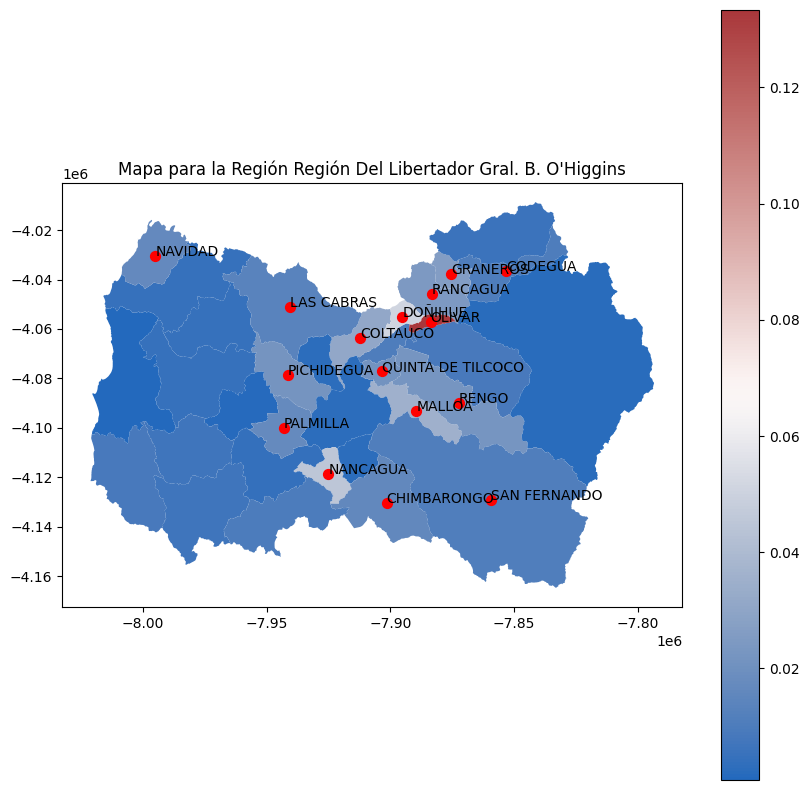

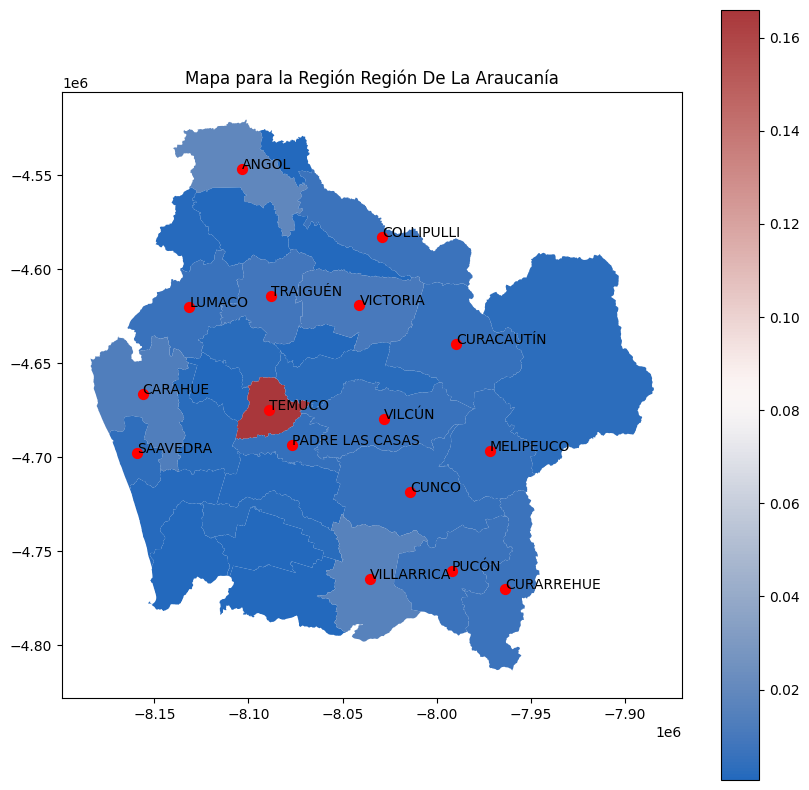

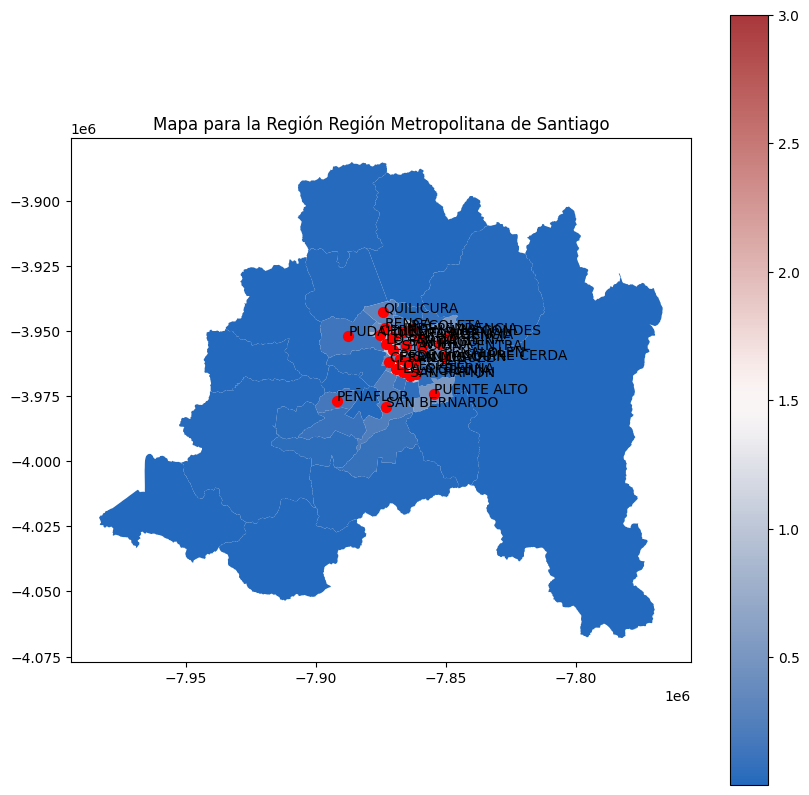

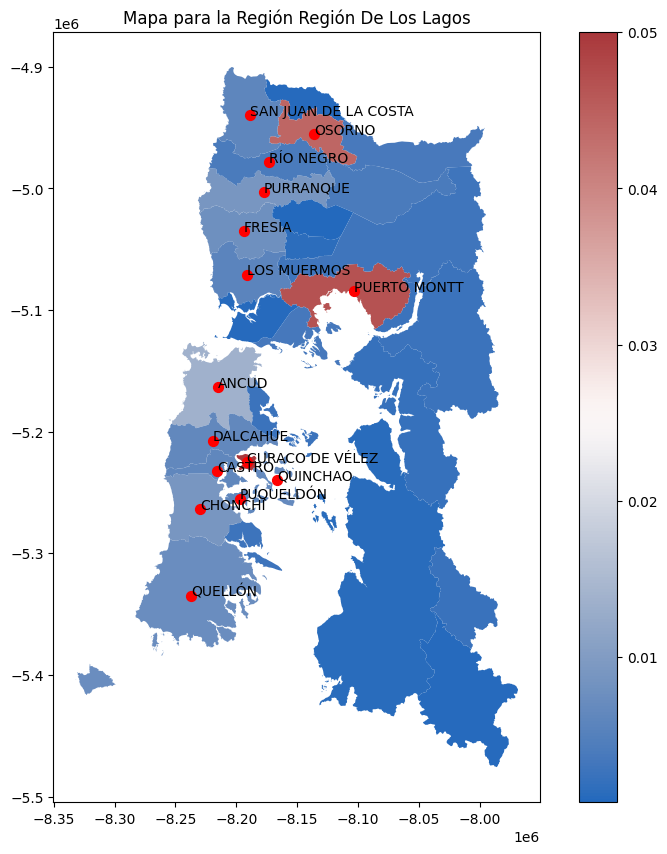

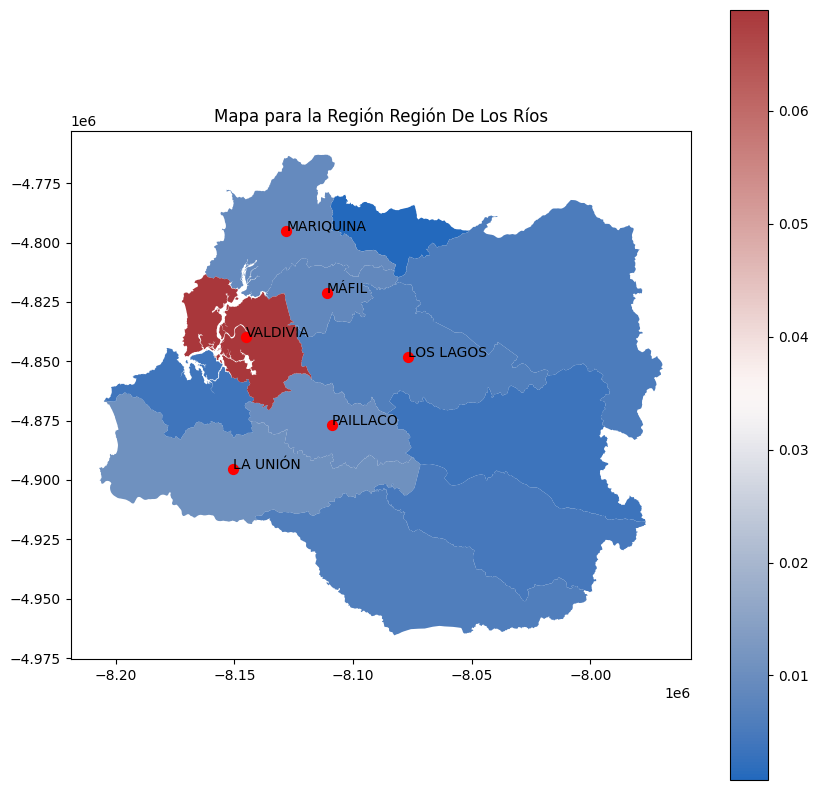

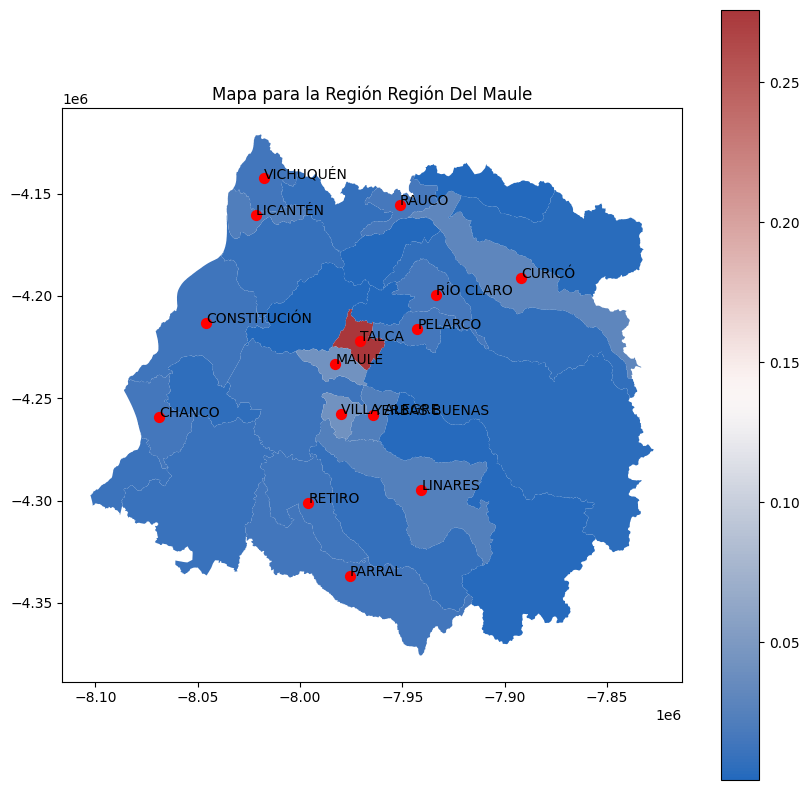

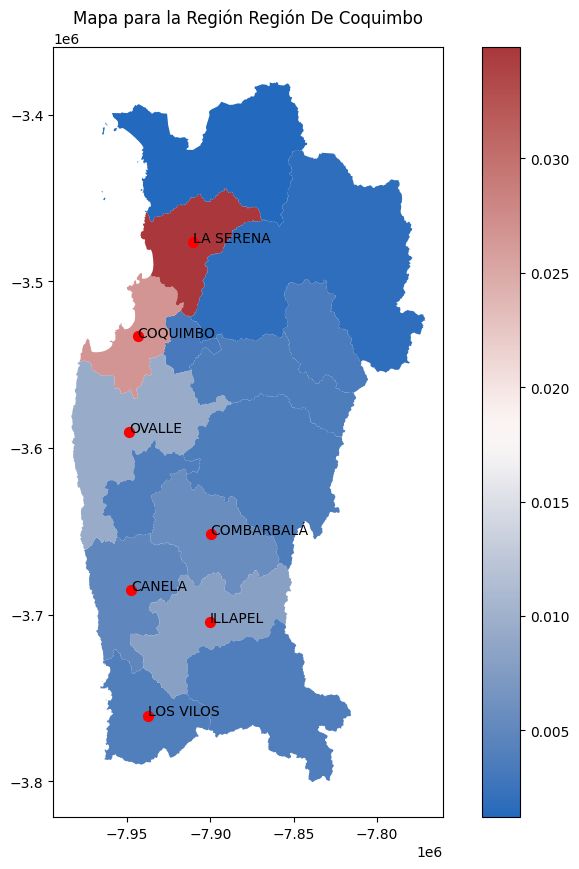

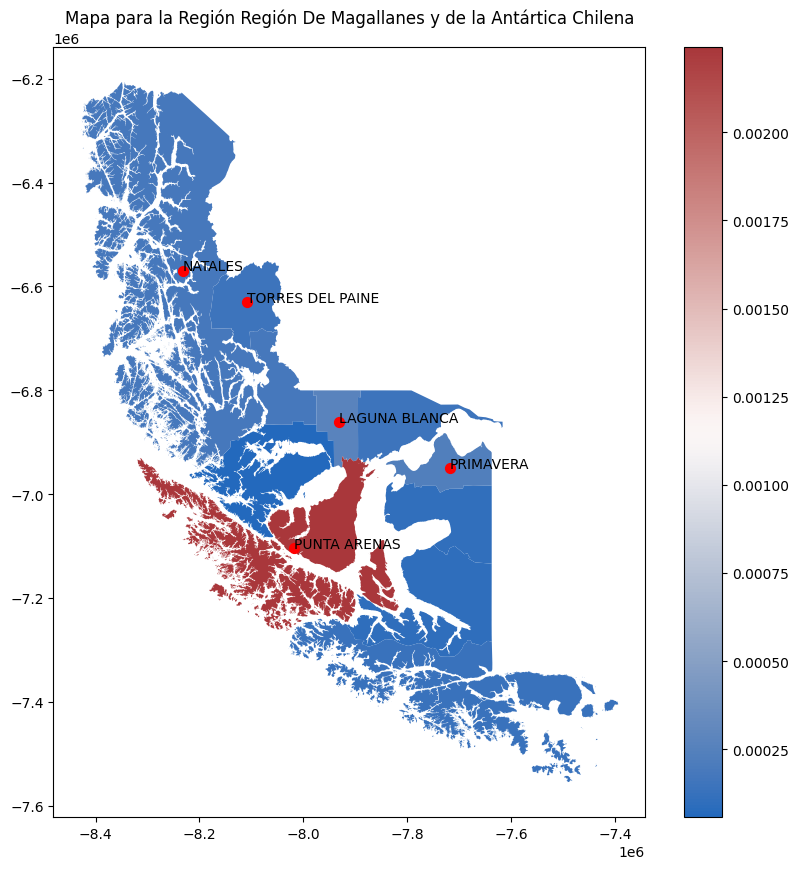

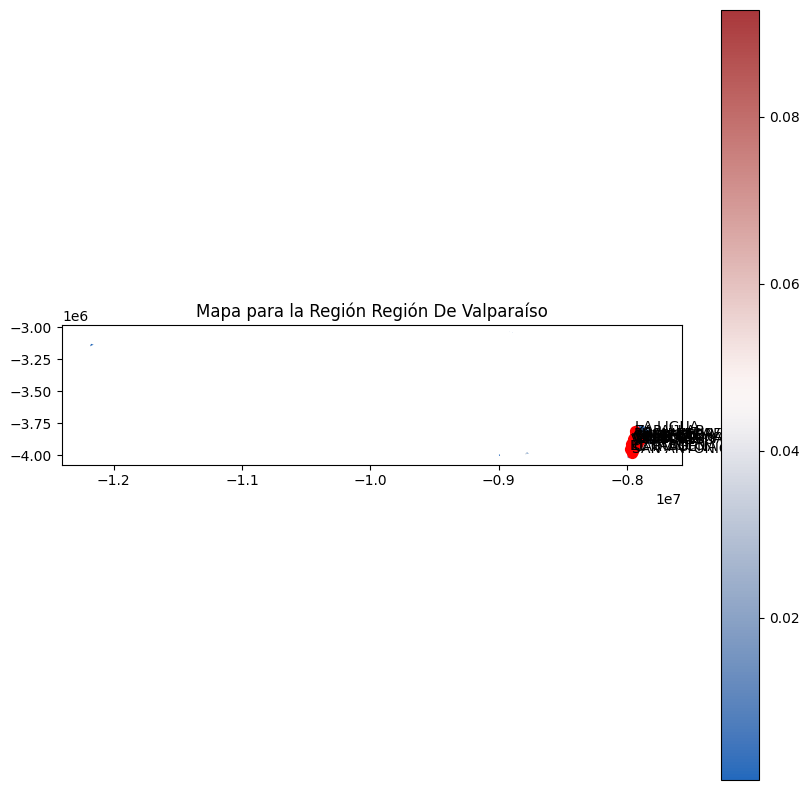

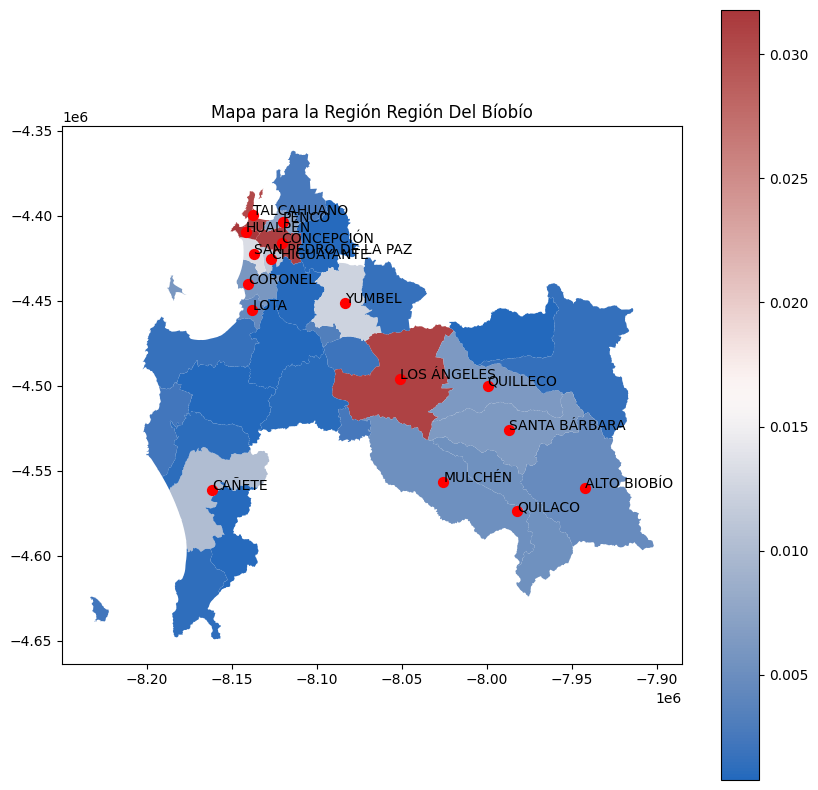

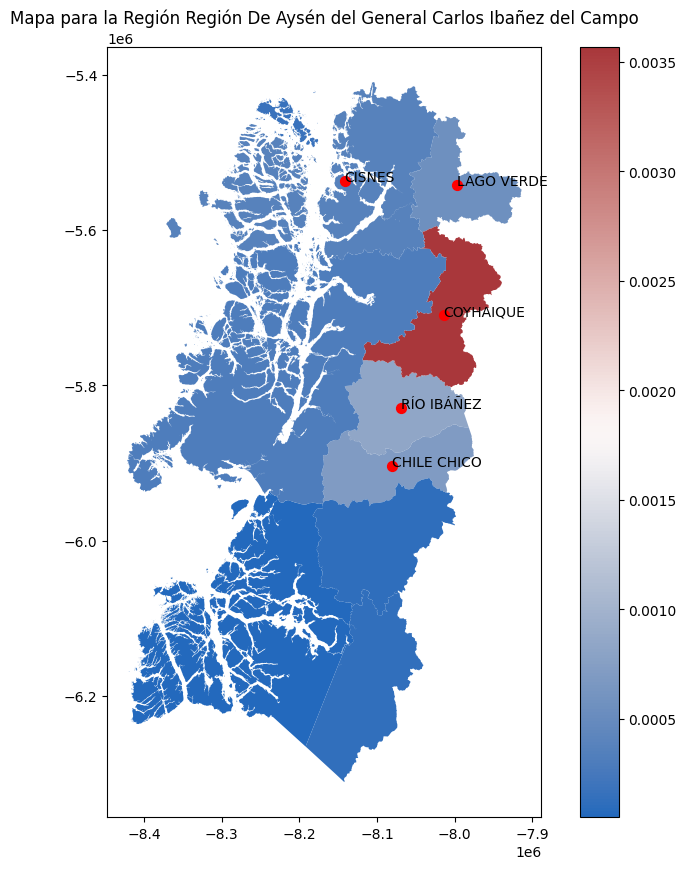

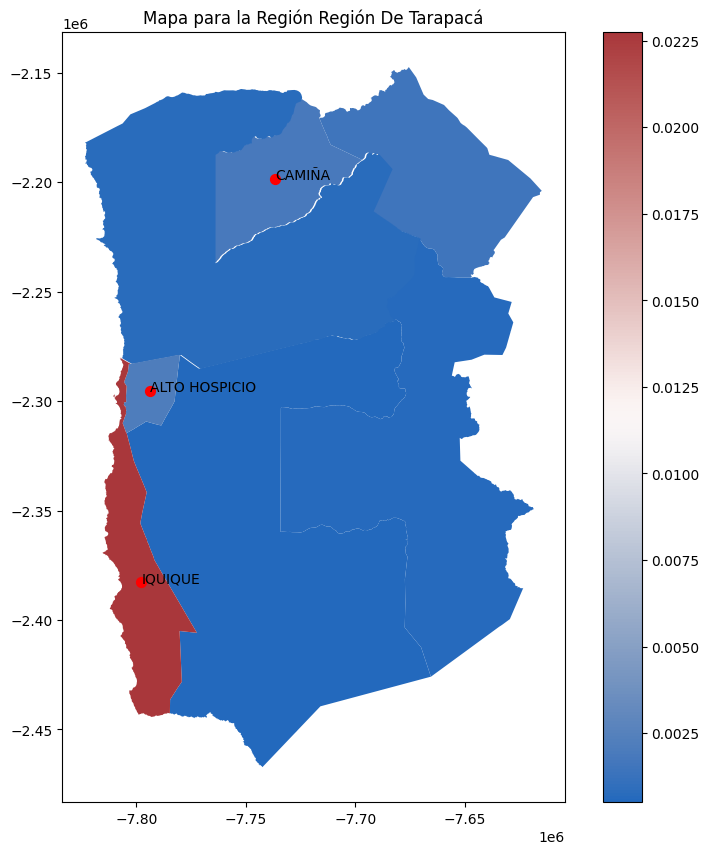

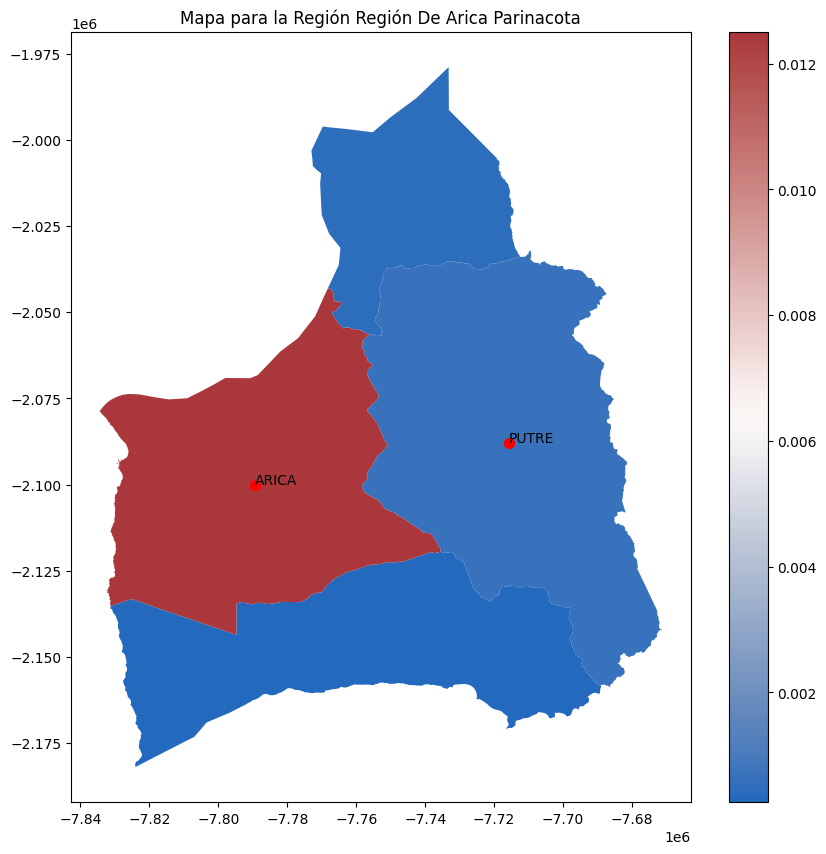

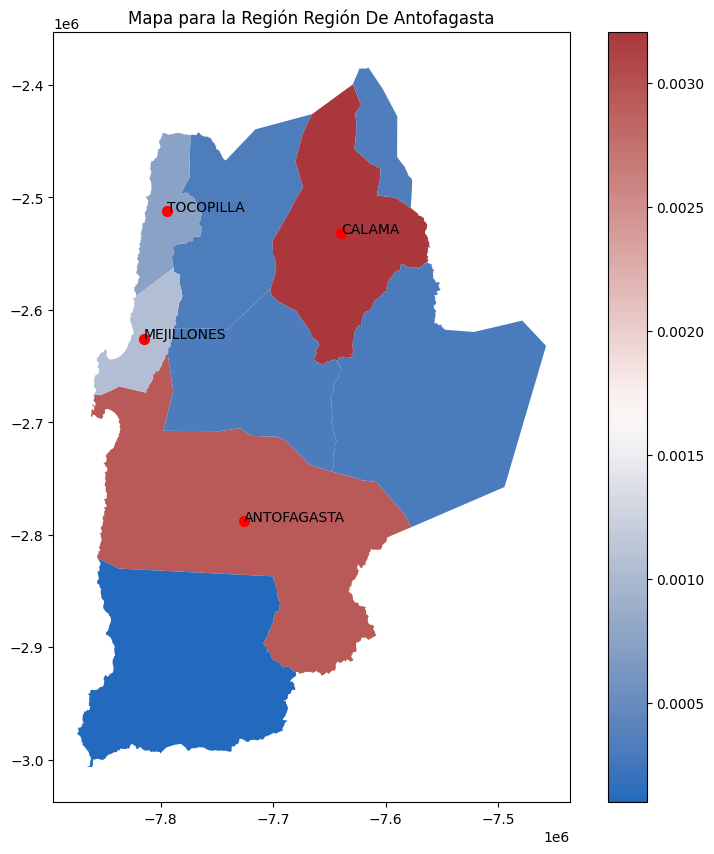

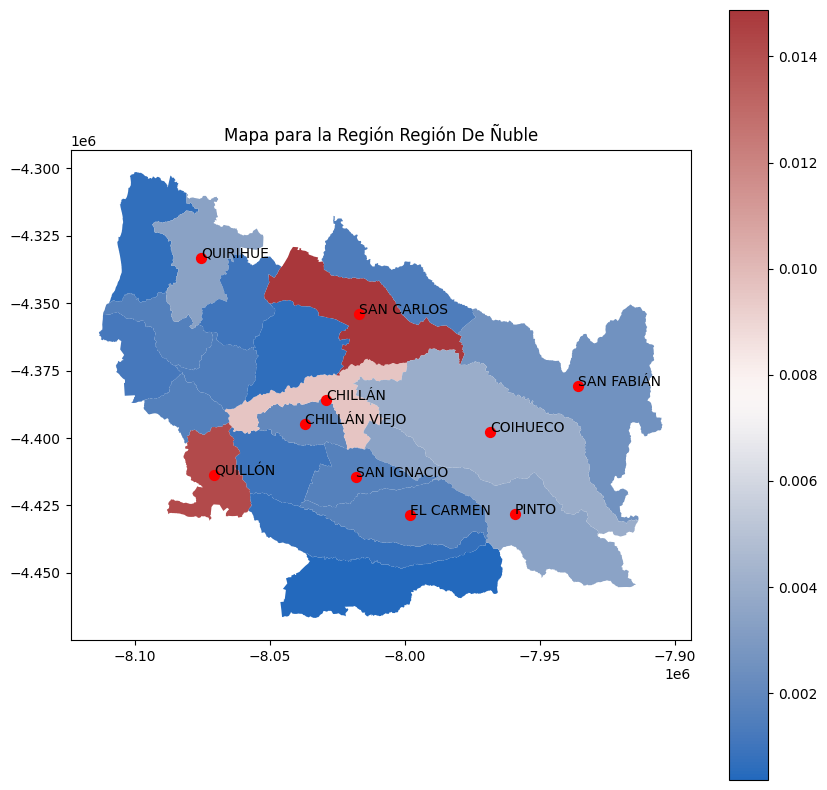

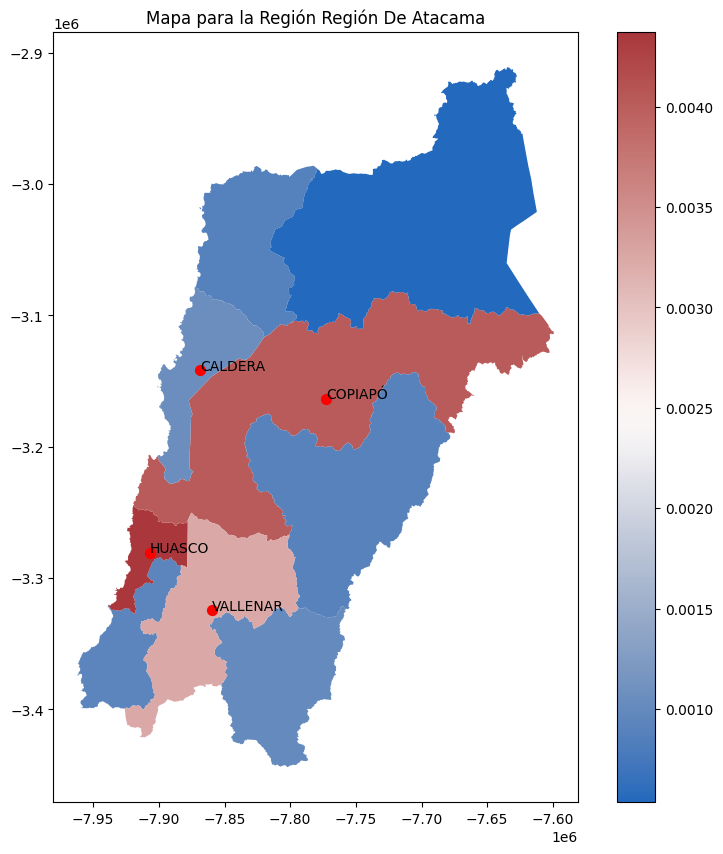

In [323]:
regiones = gdf["nombre_región"].unique()
var = "densidad_hospital_x_km2"
for region in regiones:
    gdf_region = gdf[gdf["nombre_región"] == region]
    gdf_region.plot(column=var, cmap='vlag', legend=True, figsize=(10, 10))
    q = gdf_region[var].quantile(0.7)
    gdf_region_filtered = gdf_region[gdf_region[var] > q]


    for idx, row in gdf_region_filtered.iterrows():
        plt.scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50) 
        plt.annotate(text=row["nombre_comuna"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='black')

    plt.title(f'Mapa para la Región {region}')
    plt.show()

### Laboratorios Chile

In [40]:
df_hospitales_1.columns

Index(['código_vigente', 'código_región', 'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia'],
      dtype='object', name=0)

In [51]:
df_laboratorios_1 = df_hospitales[(~df_hospitales["tipo_de_prestador_sistema_de_salud"].isin(['Fuerzas Armadas y de Orden', 'Institución Medicina Legal']))]
df_laboratorios_1 = df_hospitales_1[(df_hospitales_1["tipo_establecimiento_(unidad)"].isin(['Laboratorio Clínico',
 'Sala  Externa de Toma de Muestras (SETM)',
 'Laboratorio Clínico o Dental']))]
df_laboratorios_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 13 to 4517
Data columns (total 21 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   código_vigente                                              374 non-null    int64   
 1   código_región                                               374 non-null    int64   
 2   nombre_región                                               374 non-null    object  
 3   código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  374 non-null    float64 
 4   nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  374 non-null    object  
 5   pertenencia_al_snss                                         374 non-null    bool    
 6   tipo_establecimiento_(unidad)                               374 non-null    object  
 7   ámbito_de_funcionamiento                                    374 non-null    object 

In [52]:
laboratorios_por_comuna = pd.pivot_table(df_laboratorios_1, index=["nombre_comuna"], aggfunc="size", fill_value=0).reset_index()
laboratorios_por_comuna

nombre_comuna   0
0           ANCUD   4
1           ANGOL   3
2     ANTOFAGASTA  30
3           ARICA  10
4         CABILDO   1
..            ...  ..
80  VILLA ALEMANA   1
81     VILLARRICA   4
82       VITACURA   1
83   VIÑA DEL MAR   9
84          ÑUÑOA   2

[85 rows x 2 columns]

Hay 85 comunas en chile con laboratorios de 346

In [55]:
laboratorios_por_provincia = pd.pivot_table(df_laboratorios_1, index=["nombre_provincia"], aggfunc="size", fill_value=0).reset_index()
laboratorios_por_provincia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   nombre_provincia  41 non-null     object
 1   0                 41 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 784.0+ bytes


41 provincias tienen laboratorios de 54

In [56]:
laboratorios_por_region = pd.pivot_table(df_laboratorios_1, index=["nombre_región"], aggfunc="size", fill_value=0).reset_index()
laboratorios_por_region

nombre_región   0
0                               Región De Antofagasta  44
1                          Región De Arica Parinacota  10
2                                   Región De Atacama  22
3   Región De Aysén del General Carlos Ibañez del ...   2
4                                  Región De Coquimbo  32
5                              Región De La Araucanía  22
6                                 Región De Los Lagos  30
7                                  Región De Los Ríos  15
8      Región De Magallanes y de la Antártica Chilena   7
9                                  Región De Tarapacá  13
10                               Región De Valparaíso  33
11                                    Región De Ñuble  10
12                                  Región Del Bíobío  25
13           Región Del Libertador Gral. B. O'Higgins  25
14                                   Región Del Maule  30
15                   Región Metropolitana de Santiago  54

Todas las regiones de chile tienen algun laboratorio